# 1. Introduction

This document presents an intensive exploratory loan_data analysis (EDA) and statistical analysis of a loan status loan_dataset. The goal is to uncover patterns, relationships, and insights that can help predict loan statuss. The analysis includes:

- loan_data preprocessing and cleaning
- Univariate analysis with advanced visualizations
- Bivariate and multivariate analysis
- Correlation analysis with sophisticated visualizations
- Feature importance and selection
- Statistical modeling and predictive analysis
- Advanced dimensionality reduction and visualization techniques

Let's begin by loading and examining the loan_dataset.

# 2. loan_data Loading and Initial Exploration

In [177]:
# Use librarian to load and manage libraries
librarian::shelf(
  # Data manipulation and tidyverse
  tidyverse, tidymodels, janitor, skimr,
  
  # Visualization
  GGally, corrplot, plotly, viridis, 
  ggthemes, ggridges, scales, vcd, 
  RColorBrewer, ggraph, 
  
  # Machine Learning and Statistical Tools
  pROC, factoextra, cluster, 
  MASS, Rtsne, tsne, umap, 
  caTools, PCAtest,naniar,
  
  # Additional Utilities
  conflicted, gridExtra, 
  kableExtra, DT, 
  igraph, qgraph, 
  entropy
)

# Resolve conflicts
conflicted::conflicts_prefer(dplyr::select)
tidymodels_prefer()

# Custom ggplot theme
create_custom_theme <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}

# Data loading and preprocessing function
prepare_loan_data <- function(file_path, sample_size = 50000) {
  # Read the CSV file
  loan_data <- read_csv(file_path, show_col_types = FALSE) %>%
    clean_names() %>%
    select(-id)
  
  # Set random seed for reproducibility
  set.seed(42)
  # Split the dataset
  split_ratio <- 50000 / nrow(loan_data)
  split_index <- sample.split(loan_data$status, SplitRatio = split_ratio)
  data <- loan_data[split_index, ]
  
  # Print data information
  message("Original dataset dimensions:", nrow(loan_data), "rows,", ncol(loan_data), "columns\n")
  message("Sampled dataset dimensions:", nrow(data), "rows,", ncol(data), "columns\n")
  
  # Print status distribution
  message("Status distribution in original dataset:")
  print(prop.table(table(loan_data$status)))
  
  message("Status distribution in sampled dataset:")
  print(prop.table(table(data$status)))
  
  return(data)
}

# Main script execution
main <- function() {
  # Prepare the loan data
  data <- prepare_loan_data("dataset/Loan_Default.csv")
  data <- data %>% 
    mutate_if(is.character, as.factor)
  
  # Generate summary statistics
  summary_stats <- data %>%
    skim() %>%
    kable(caption = "Summary statistics for the loan data")
  
  print(summary_stats)
}

# Run the main script
result <- main()


[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::select over any other package.
Original dataset dimensions:148670rows,33columns

Sampled dataset dimensions:50000rows,33columns

Status distribution in original dataset:

        0         1 
0.7535549 0.2464451 
Status distribution in sampled dataset:

      0       1 
0.75356 0.24644 


Table: Summary statistics for the loan data

|skim_type |skim_variable             | n_missing| complete_rate|factor.ordered | factor.n_unique|factor.top_counts                             | numeric.mean|   numeric.sd|   numeric.p0|  numeric.p25|  numeric.p50|  numeric.p75| numeric.p100|numeric.hist |
|:---------|:-------------------------|---------:|-------------:|:--------------|---------------:|:---------------------------------------------|------------:|------------:|------------:|------------:|------------:|------------:|------------:|:------------|
|factor    |loan_limit                |      1178|       0.97644|FALSE    

## Missing loan_data Analysis


               loan_limit                    gender             approv_in_adv                 loan_type 
                        0                         0                         0                         0 
             loan_purpose    business_or_commercial               loan_amount          rate_of_interest 
                        0                         0                         0                         0 
     interest_rate_spread           upfront_charges                      term         neg_ammortization 
                        0                         0                         0                         0 
           property_value                    income               credit_type              credit_score 
                        0                         0                         0                         0 
 co_applicant_credit_type                       age submission_of_application                       ltv 
                        0                         0    

Warning messages:
1: No shared levels found between `names(values)` of the manual scale and the data's fill values. 
2: No shared levels found between `names(values)` of the manual scale and the data's fill values. 


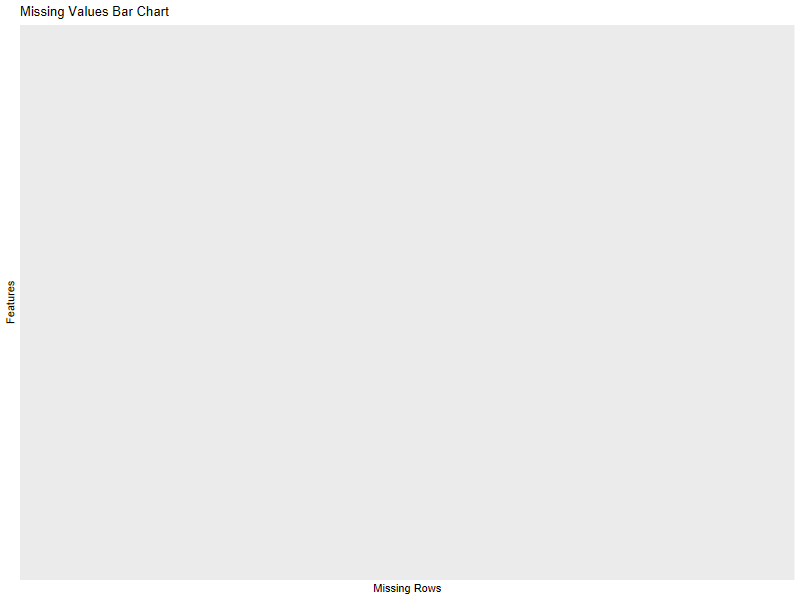

In [178]:
analyze_and_impute_missing <- function(data) {
  # Missing value visualization
  print(plot_missing(data, missing_only = TRUE, title = "Missing Values Bar Chart"))
  
  # Remove zero-variance columns and apply KNN imputation
  data <- recipe(status ~ ., data) %>% 
    step_nzv(all_predictors()) %>% 
    step_impute_knn(all_predictors()) %>% 
    prep() %>% 
    bake(new_data = NULL)

  # Sanity Checks
  print(colSums(is.na(data)))
  
  return(data)
}

# Apply the function
data <- analyze_and_impute_missing(data)

# 3. Univariate Analysis

## 3.1 Distribution of Numeric loan_amounts

In [188]:
# Identify numeric and categorical columns
numeric_cols <- names(select(data, where(is.numeric)))
categorical_cols <- names(select(data, where(negate(is.numeric))))
numeric_data <- data %>% 
  select(any_of(c(numeric_cols, "status"))) %>% 
  pivot_longer(cols = -status, names_to = "features", values_to = "values")

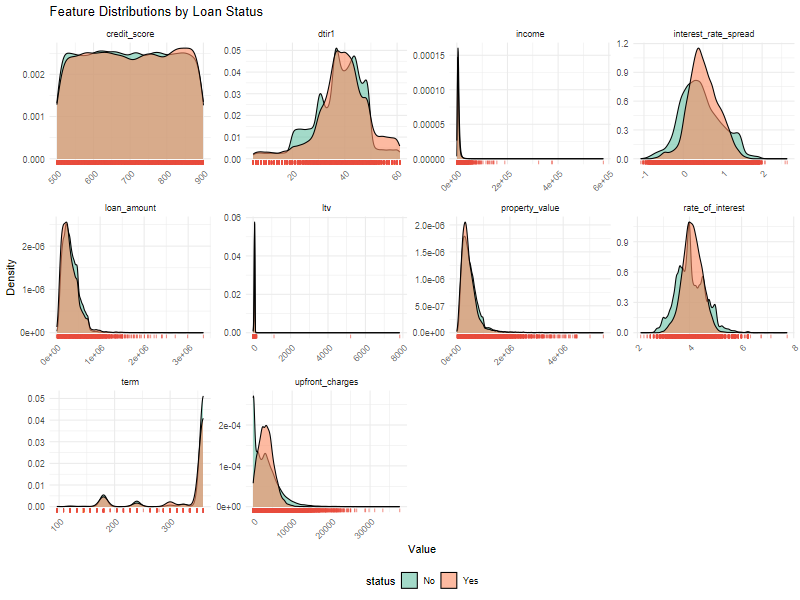

In [189]:
status_counts <- function(data = data) {
  p1 <- data %>% 
    count(status) %>% 
    mutate(percentage = n / sum(n) * 100)

  ggplot(data, aes(status, fill = status)) +
    geom_bar(width = 0.7) +
    geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
    scale_fill_viridis_d(option = "D") +
    labs(title = "Loan Status Counts",
      subtitle = paste("Total loans =", nrow(data)),
      fill = "Loan Status")
  
  return(p1)
}


feature_distributions <- function(data = data){
  p2 <- ggplot(numeric_data, aes(values, fill = status)) +
  geom_density(alpha = 0.6) +
  geom_rug(alpha = 0.6, color = "#e74c3c") +
  facet_wrap(~features, scales = "free") +
  labs(title = "Feature Distributions by Loan Status",
  x = "Value", y = "Density") +
  scale_fill_manual(values = c("No" = "#66c2a5", 
  "Yes" = "#fc8d62")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
     legend.position = "bottom")
  
  return(p2)
}




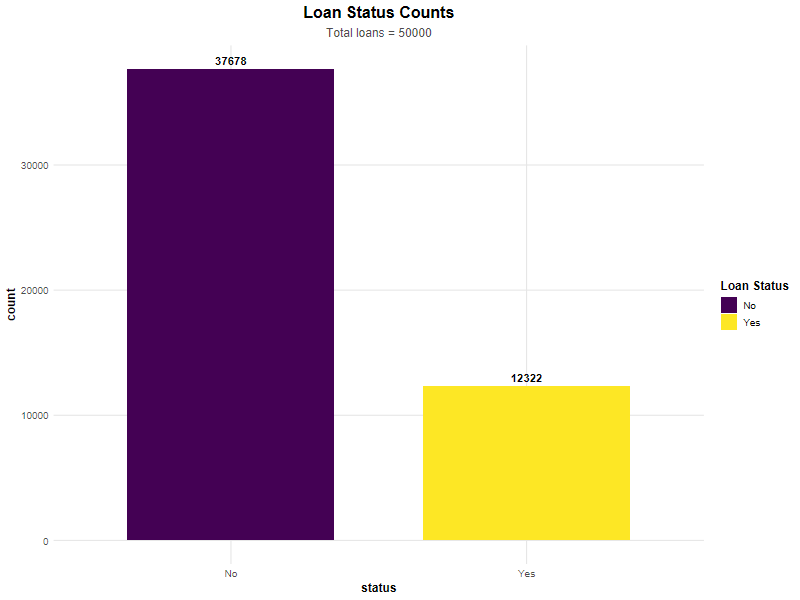

In [22]:
status_counts <- data %>% 
  count(status) %>% 
  mutate(percentage = n / sum(n) * 100)

ggplot(data, aes(status, fill = status)) +
  geom_bar(width = 0.7) +
  geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
  scale_fill_viridis_d(option = "D") +
  labs(title = "Loan Status Counts",
      subtitle = paste("Total loans =", nrow(data)),
      fill = "Loan Status") +
  theme_custom() -> p1

numeric_cols <- data %>% 
  select_if(is.numeric) %>% 
  names()

numeric_data <- data %>% 
  select(any_of(c(numeric_cols, "status"))) %>% 
  pivot_longer(cols = -status, names_to = "features", values_to = "values")



# Function to plot boxplots with violin overlay
p3 <- function(data, variable) {
  q <- quantile(data[[variable]], probs = c(0.25, 0.75), na.rm = TRUE)
  iqr <- diff(q)
  bounds <- q + c(-1.5, 1.5) * iqr
  outlier_pct <- mean(data[[variable]] < bounds[1] | data[[variable]] > bounds[2], na.rm = TRUE) * 100
  
  ggplot(data, aes(y = .data[[variable]], x = "")) +
    geom_violin(fill = "#9b59b6", alpha = 0.6) +
    geom_boxplot(width = 0.1, fill = "#3498db", alpha = 0.7, outlier.color = "#e74c3c") +
    labs(
      title = paste("Distribution of", variable),
      subtitle = sprintf("IQR = %.2f | Outliers = %.2f%%", iqr, outlier_pct),
      y = variable, x = ""
    ) +
    theme_minimal()
}

# Generate and arrange plots for first 9 numeric features
plots <- lapply(head(numeric_cols, 9), p3, data = data)
grid.arrange(grobs = plots, ncol = 3)

categorical_cols <- data %>% 
  select(where(~ !is.numeric(.))) %>% 
  names()

 
options(repr.plot.height = 24, repr.plot.width = 24)

if (length(categorical_cols) > 0) {
  
  
  plot_bar <- function(data, variable) {
    freq_table <- table(data[[variable]])
    freq_df <- as.data.frame(freq_table) %>%
      rename(Category = Var1, Count = Freq) %>%
      mutate(Percentage = Count / sum(Count) * 100) %>%
      arrange(desc(Count))
    
    # Compute Shannon's entropy
    entropy_value <- entropy(freq_df$Count, unit = "log2")
    norm_entropy <- entropy_value / log2(nrow(freq_df))
    
    # Plot
    ggplot(freq_df, aes(reorder(Category, -Count), Count)) +
      geom_bar(stat = "identity", fill = "#2ecc71", alpha = 0.8) +
      geom_text(aes(label = sprintf("%.1f%%", Percentage)), 
                vjust = -0.5, color = "black", size = 3) +
      labs(
        title = paste("Distribution of ", variable),
        subtitle = sprintf("Categories: %d | Entropy: %.2f | Norm. Entropy: %.2f", 
                           nrow(freq_df), entropy_value, norm_entropy),
        x = "", y = "Count"
      ) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
  }
  
  # Auto-adjust grid layout
  num_plots <- min(9, length(categorical_cols))  # Max 9 plots
  num_cols <- ceiling(sqrt(num_plots))  # Dynamic columns
  num_rows <- ceiling(num_plots / num_cols)  # Dynamic rows
  
  # Generate plots
  plot_list <- lapply(head(categorical_cols, num_plots), function(col) plot_bar(data, col))
  grid::grid.newpage()
  do.call(grid.arrange, c(plot_list, ncol = num_cols, nrow = num_rows))
}


## Distribution of categorical features

In [25]:
categorical_cols <- data %>% 
  select(where(~ !is.numeric(.))) %>% 
  names()

 
options(repr.plot.height = 24, repr.plot.width = 24)

if (length(categorical_cols) > 0) {
  
  
  plot_bar <- function(data, variable) {
    freq_table <- table(data[[variable]])
    freq_df <- as.data.frame(freq_table) %>%
      rename(Category = Var1, Count = Freq) %>%
      mutate(Percentage = Count / sum(Count) * 100) %>%
      arrange(desc(Count))
    
    # Compute Shannon's entropy
    entropy_value <- entropy(freq_df$Count, unit = "log2")
    norm_entropy <- entropy_value / log2(nrow(freq_df))
    
    # Plot
    ggplot(freq_df, aes(reorder(Category, -Count), Count)) +
      geom_bar(stat = "identity", fill = "#2ecc71", alpha = 0.8) +
      geom_text(aes(label = sprintf("%.1f%%", Percentage)), 
                vjust = -0.5, color = "black", size = 3) +
      labs(
        title = paste("Distribution of ", variable),
        subtitle = sprintf("Categories: %d | Entropy: %.2f | Norm. Entropy: %.2f", 
                           nrow(freq_df), entropy_value, norm_entropy),
        x = "", y = "Count"
      ) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
  }
  
  # Auto-adjust grid layout
  num_plots <- min(9, length(categorical_cols))  # Max 9 plots
  num_cols <- ceiling(sqrt(num_plots))  # Dynamic columns
  num_rows <- ceiling(num_plots / num_cols)  # Dynamic rows
  
  # Generate plots
  plot_list <- lapply(head(categorical_cols, num_plots), function(col) plot_bar(data, col))
  grid::grid.newpage()
  do.call(grid.arrange, c(plot_list, ncol = num_cols, nrow = num_rows))
}


 [1] "loan_limit"                "gender"                    "approv_in_adv"            
 [4] "loan_type"                 "loan_purpose"              "credit_worthiness"        
 [7] "open_credit"               "business_or_commercial"    "neg_ammortization"        
[10] "interest_only"             "lump_sum_payment"          "construction_type"        
[13] "occupancy_type"            "secured_by"                "total_units"              
[16] "credit_type"               "co_applicant_credit_type"  "age"                      
[19] "submission_of_application" "region"                    "security_type"            
[22] "status"                   

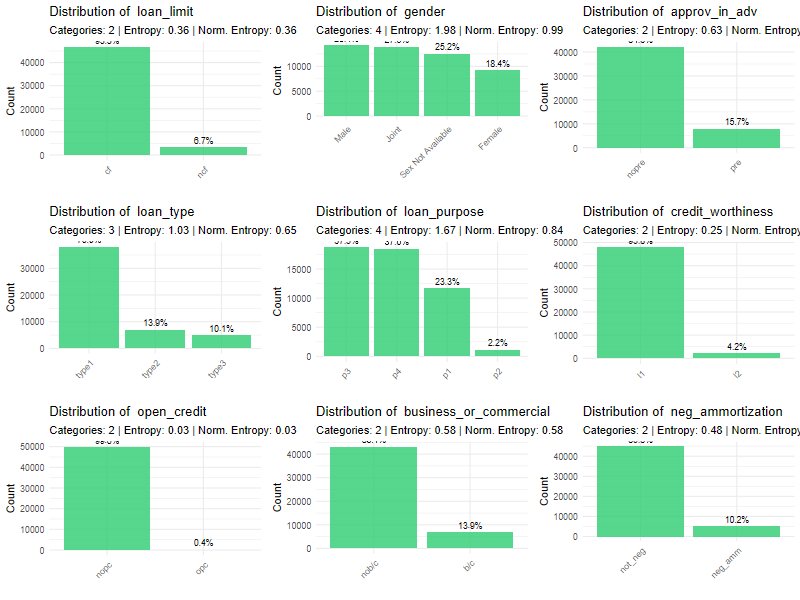

# 4. Bivariate Analysis

## 4.1 Relationship Between Target Variable and Numeric Predictors

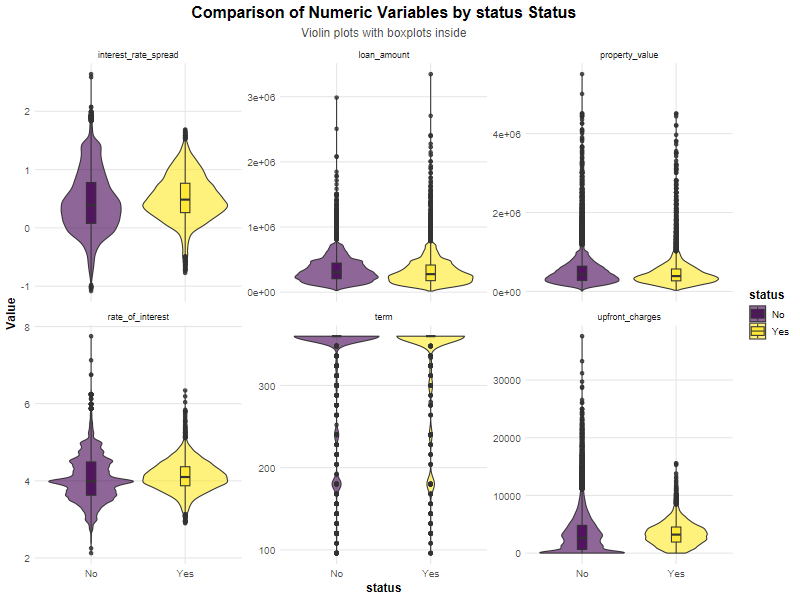

In [27]:
target_var <- "status"
violin_plot_data <- data %>%
    select(all_of(c(target_var, numeric_cols[1:min(6, length(numeric_cols))]))) %>%
    pivot_longer(cols = -all_of(target_var), names_to = "Variable", values_to = "Value")

  
ggplot(violin_plot_data, aes(x = .data[[target_var]], y = Value, fill = .data[[target_var]])) +
  geom_violin(alpha = 0.6) +
  geom_boxplot(width = 0.1, alpha = 0.8) +
  scale_fill_viridis_d() +
  facet_wrap(~ Variable, scales = "free_y", ncol = 3) +
  labs(
    title = "Comparison of Numeric Variables by status Status",
    subtitle = "Violin plots with boxplots inside",
    x = target_var,
    y = "Value"
  ) +
  theme_custom()

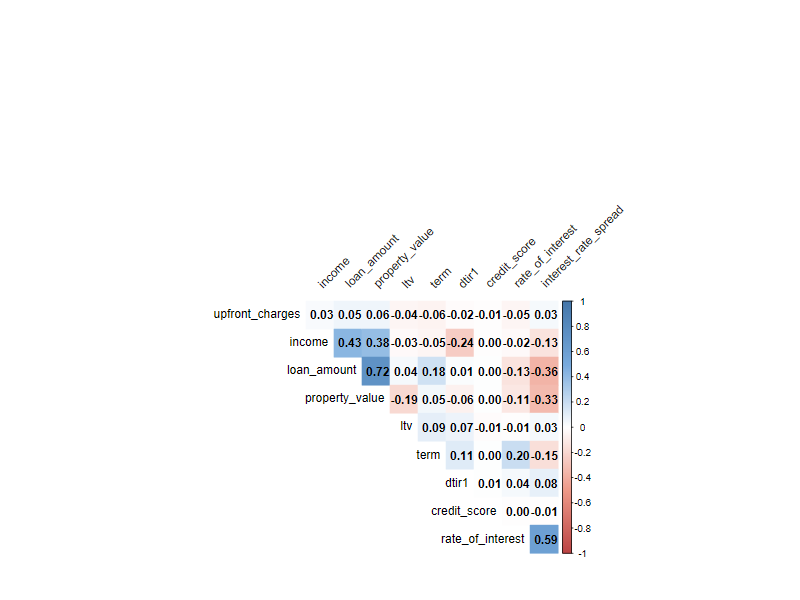

In [28]:
options(repr.plot.height = 14, repr.plot.width = 14)
cor_matrix <- cor(data[, numeric_cols], use = "pairwise.complete.obs")
col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
corrplot(cor_matrix, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
        sig.level = 0.01, insig = "blank", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

### Network plot of correlations

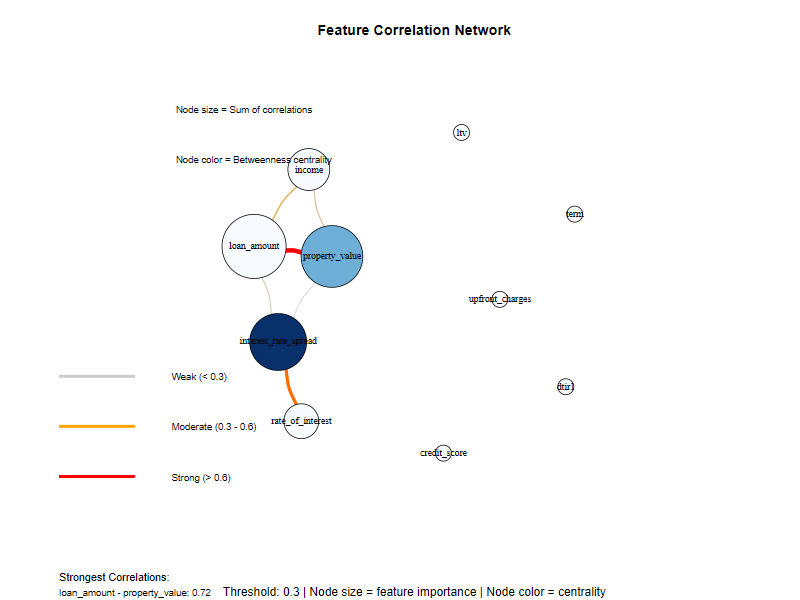

In [29]:

# Set threshold for "high correlation"
threshold <- 0.3
# Define correlation strength labels and corresponding colors
legend_labels <- c("Weak (< 0.3)", "Moderate (0.3 - 0.6)", "Strong (> 0.6)")
correlation_colors <- c("#CCCCCC", "#FFA500", "#FF0000")  
 


# Apply threshold to correlation matrix
cor_filtered <- cor_matrix
cor_filtered[abs(cor_filtered) < threshold] <- 0  # Filter weak correlations
diag(cor_filtered) <- 0  # Remove self-correlations

# Ensure no missing values
cor_filtered[is.na(cor_filtered)] <- 0

# Create network graph from adjacency matrix
net <- graph_from_adjacency_matrix(
  abs(cor_filtered),
  mode = "undirected",
  weighted = TRUE,
  diag = FALSE
)

# Calculate node metrics
btw <- betweenness(net, normalized = TRUE)
strength <- strength(net)

# Set vertex attributes
V(net)$size <- 10 + 30 * rescale(strength)  # Normalize sizes
V(net)$color <- colorRampPalette(brewer.pal(9, "Blues"))(100)[cut(rescale(btw), breaks = 100, labels = FALSE)]

# Set edge attributes
E(net)$width <- 1 + 5 * rescale(E(net)$weight)
E(net)$color <- colorRampPalette(c("#CCCCCC", "#FFA500", "#FF0000"))(100)[cut(rescale(E(net)$weight), breaks = 100, labels = FALSE)]

# Create layout
set.seed(42)
graph_layout <- layout_with_fr(net)

# Plot network
plot(net,
     layout = graph_layout,
     main = "Feature Correlation Network",
     sub = paste("Threshold:", threshold, "| Node size = feature importance | Node color = centrality"),
     vertex.label.color = "black",
     vertex.label.cex = 0.8,
     edge.curved = 0.2,
     edge.arrow.size = 0,
     margin = c(0.15, 0.15, 0.15, 0.15)
)

# Move the correlation strength legend slightly left
legend("bottomleft",
       legend = legend_labels,
       col = correlation_colors,
       lwd = 4,
       bty = "n",
       cex = 0.8,
       inset = c(-0.1, 0) # Move it slightly outside the plot
)


# Move the node properties legend slightly outside the plot
legend("topright",
       legend = c("Node size = Sum of correlations", 
                  "Node color = Betweenness centrality"),
       bty = "n",
       cex = 0.8,
       inset = c(-0.2, 0), # Move it slightly outside
       xpd = TRUE 
)


# Add top correlations
if (ecount(net) > 0) {
  top_edges <- head(E(net)[order(E(net)$weight, decreasing = TRUE)], 5)
  if (length(top_edges) > 0) {
    mtext("Strongest Correlations:", side = 1, line = 3, adj = 0, cex = 0.9)
    for (i in 1:length(top_edges)) {
      edge <- top_edges[i]
      edge_ends <- ends(net, edge)
      v1 <- V(net)[edge_ends[1]]$name
      v2 <- V(net)[edge_ends[2]]$name
      weight <- round(E(net)[edge]$weight, 2)
      mtext(paste0(v1, " - ", v2, ": ", weight), side = 1, line = 3 + i, adj = 0, cex = 0.8)
    }
  }
}


Community membership:
Community 1 : loan_amount property_value income 
Community 2 : rate_of_interest interest_rate_spread 
Community 3 : upfront_charges 
Community 4 : term 
Community 5 : credit_score 
Community 6 : ltv 
Community 7 : dtir1 


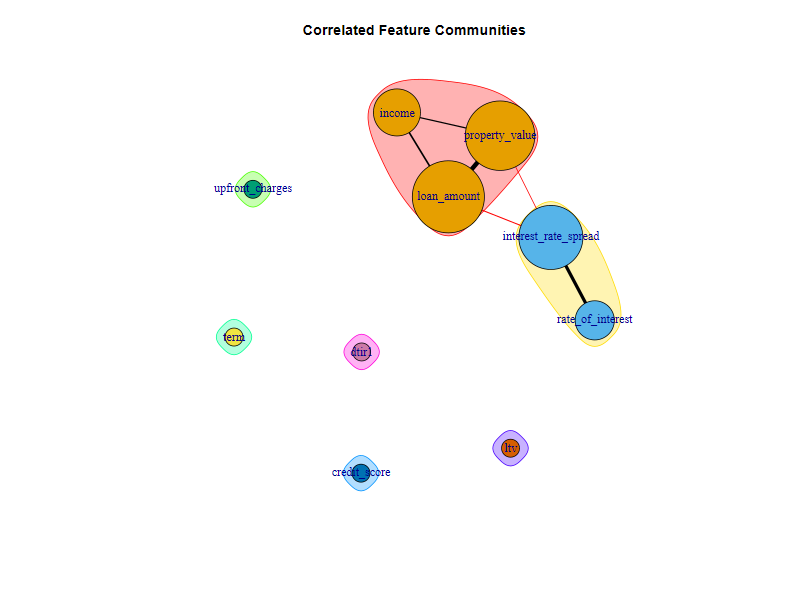

In [30]:
# Detect communities in the network
comm <- cluster_louvain(net)

plot(comm, net, 
     layout = layout_with_fr(net),
     main = "Correlated Feature Communities")

cat("Community membership:\n")
for (i in 1:max(membership(comm))) {
  cat("Community", i, ":", names(membership(comm))[membership(comm) == i], "\n")
}


# 5. Multivariate Analysis

## 5.1 Advanced Scatter Plot Matrix

# Select a subset of the most interesting numeric variables

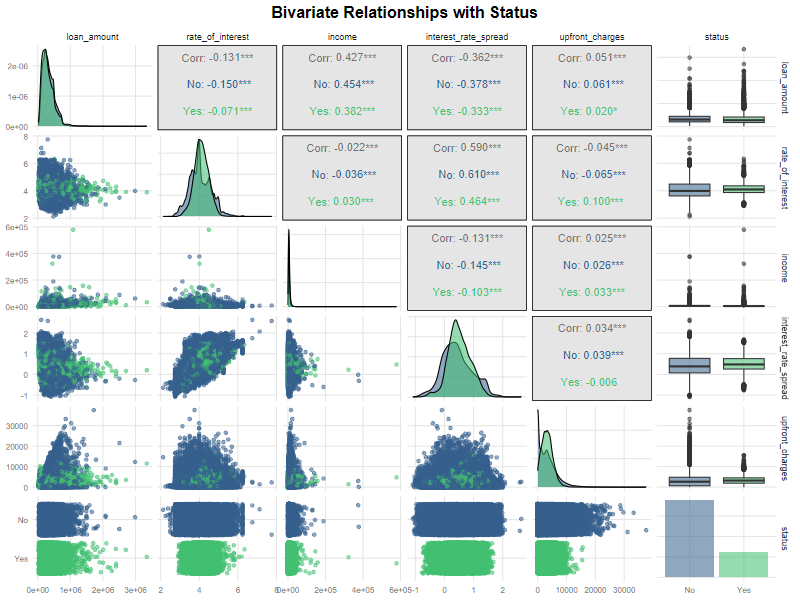

In [31]:
# Select a few key variables for bivariate analysis
key_vars <- c("loan_amount", "rate_of_interest", "income","interest_rate_spread", "upfront_charges", "status")

data %>%
  select(all_of(key_vars)) %>%
  ggpairs(aes(color = status, alpha = 0.5),
          upper = list(continuous = "cor", combo = "box_no_facet"),
          lower = list(continuous = "points", combo = "dot_no_facet"),
          diag = list(continuous = "densityDiag"),
          progress = FALSE) +
  scale_color_viridis_d(option = "D", begin = 0.3, end = 0.7) +
  scale_fill_viridis_d(option = "D", begin = 0.3, end = 0.7) +
  labs(title = "Bivariate Relationships with Status") +
  theme(axis.text = element_text(size = 8),
        strip.text = element_text(size = 9))

## 5.2 Dimensionality Reduction and Visualization
### Sparse PCA

Sparse PCA aims to find principal components that explain the maximum variance while having as few non-zero loadings as possible. This helps identify the most important features (genes, clinical markers, etc.) that characterize different cancer subtypes.

In [32]:
num_data <- data %>% 
  select(any_of(numeric_cols))

# Examine the dataset structure
dim_desc <- paste("Dataset dimensions:", paste(dim(num_data), collapse = "x"))
feature_desc <- paste("First few feature names:", 
                      paste(colnames(num_data)[1:5], collapse=", "), "...")
cat(dim_desc, "\n", feature_desc)

## Center and scale the data

loan_scaled <- scale(num_data)


Dataset dimensions: 50000x10 
 First few feature names: loan_amount, rate_of_interest, interest_rate_spread, upfront_charges, term ...


---------------------
Welcome to dendextend version 1.19.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



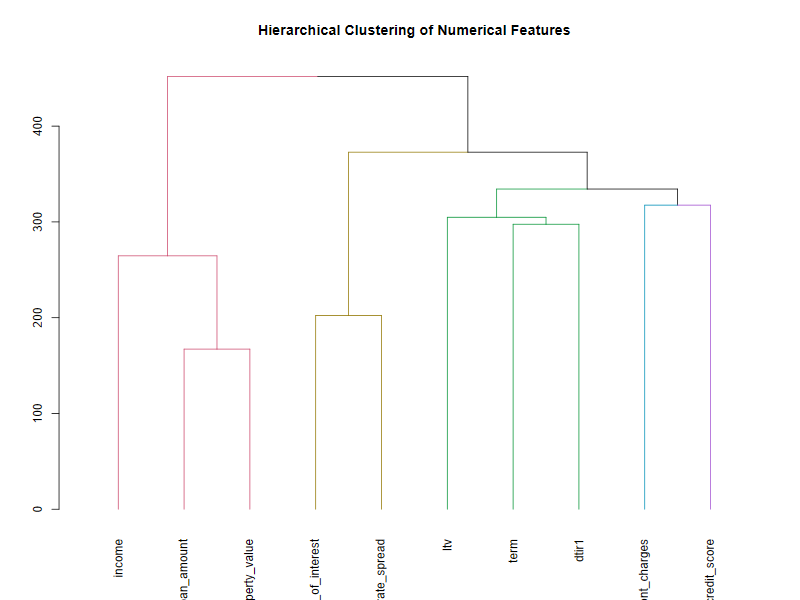

In [33]:
library(dendextend)
# Hierarchical clustering of features
feature_dist <- dist(t(loan_scaled))
feature_hclust <- hclust(feature_dist, method = "ward.D2")
feature_dend <- as.dendrogram(feature_hclust)
feature_dend <- color_branches(feature_dend, k = 5)

# Create clustering visualization
plot(feature_dend, main = "Hierarchical Clustering of Numerical Features",
     xlab = "", sub = "")

Loading required package: lars
Loaded lars 1.3

You may wish to restart and use a more efficient way 
let the argument x be the sample covariance/correlation matrix and set type=Gram 


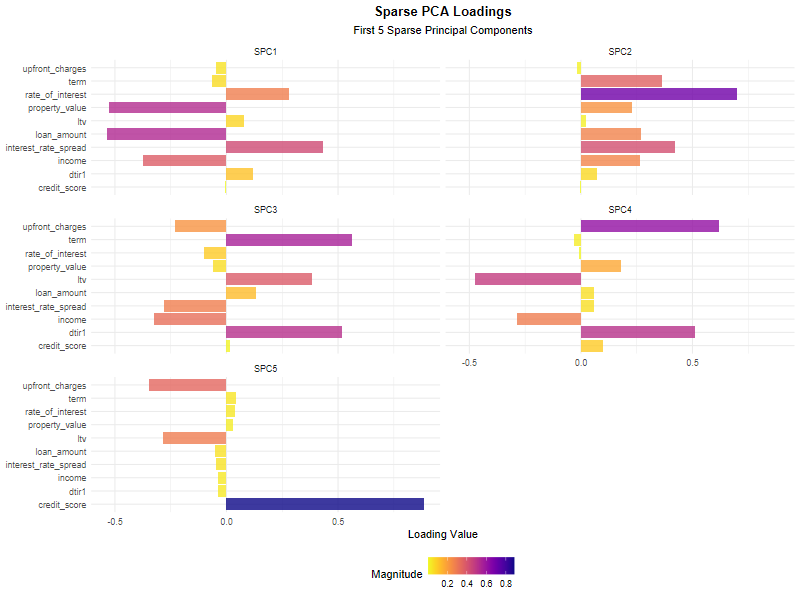

In [34]:
library(elasticnet)
library(rospca)
library(PMA)
loan_cov <- cov(loan_scaled)
sparse_pca <- spca(loan_scaled,
                  K = 5, # Number of components
                  para = c(rep(0.4, 5)), # Sparsity parameters for each component
                  type = "predictor",
                  sparse = "penalty" # How do I induce sparsity?
                )

loadings_sparse <- sparse_pca$loadings
# Prepare the data for visualization
loadings_sparse_df <- as.data.frame(loadings_sparse)
colnames(loadings_sparse_df) <- paste0("SPC", 1:ncol(loadings_sparse_df))
loadings_sparse_df$Variable <- rownames(loadings_sparse_df)
loadings_sparse_long <- pivot_longer(loadings_sparse_df,
                                    cols = starts_with("SPC"),
                                    names_to = "Component",
                                    values_to = "Loading")
# Visualize the Sparse PCA Loadings
ggplot(loadings_sparse_long, aes(Variable, Loading, fill = abs(Loading))) +
  geom_bar(stat = "identity", alpha = 0.8) +
  facet_wrap(~ Component, ncol = 2) +
  coord_flip() +
  scale_fill_viridis(option = "plasma", direction = -1) +
  labs(title = "Sparse PCA Loadings",
  subtitle = "First 5 Sparse Principal Components",
  x = NULL,
  y = "Loading Value",
  fill = "Magnitude") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
   plot.subtitle = element_text(hjust = 0.5),
   legend.position = "bottom")

## Tuning the Sparsity Parameter

The sparsity parameter controls the trade-off between variance explained and interpretability. Let's examine how different lambda values affect sparsity:

In [35]:
# Try different sparsity parameters
sparsity_levels <- seq(0.1, 0.9, 0.1)
spca_results <- list()

for (i in seq_along(sparsity_levels)) {
  spca_results[[i]] <- spca(loan_cov, K = 5, 
                           para = rep(sparsity_levels[i], 5),
                           type = "Gram", sparse = "penalty")
}

# Select optimal sparsity based on variance explained vs sparsity tradeoff
sparsity_metrics <- data.frame(
  sparsity = sparsity_levels,
  nonzero_loadings = sapply(spca_results, function(x) mean(colSums(x$loadings != 0))),
  stringsAsFactors = FALSE
)

# Function to estimate variance explained for SPCA
calc_spca_var <- function(X, loadings) {
  scores <- X %*% loadings
  explained_var <- apply(scores, 2, var)
  total_var <- sum(apply(X, 2, var))
  return(explained_var / total_var * 100)
}

# Calculate variance explained for each sparsity level
for (i in seq_along(sparsity_levels)) {
  sparsity_metrics$var_explained_pc1_5[i] <- 
    sum(calc_spca_var(loan_scaled, spca_results[[i]]$loadings)[1:5])
}

# Choose optimal sparsity level (example criterion)
best_idx <- which.max(sparsity_metrics$var_explained_pc1_5 / sparsity_metrics$nonzero_loadings)
optimal_sparsity <- sparsity_levels[best_idx]

# Display sparsity comparison
knitr::kable(sparsity_metrics, digits = 2, 
             caption = paste("Sparsity-Variance Tradeoff (Optimal: ", optimal_sparsity, ")"))



Table: Sparsity-Variance Tradeoff (Optimal:  0.4 )

| sparsity| nonzero_loadings| var_explained_pc1_5|
|--------:|----------------:|-------------------:|
|      0.1|              2.8|               69.36|
|      0.2|              2.4|               67.98|
|      0.3|              1.8|               67.16|
|      0.4|              1.6|               66.18|
|      0.5|              1.6|               66.12|
|      0.6|              1.6|               65.99|
|      0.7|              1.6|               65.73|
|      0.8|              1.6|               65.25|
|      0.9|              1.6|               64.37|

Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 


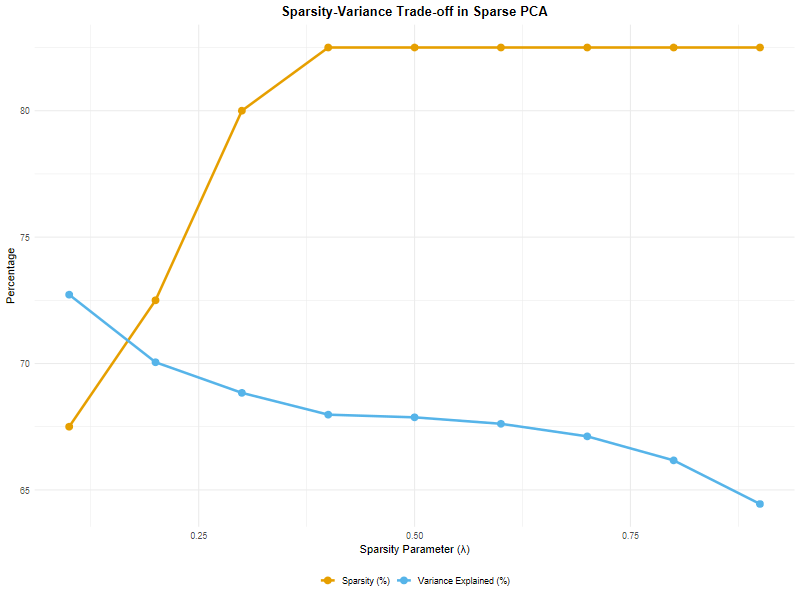

In [36]:
# Function to calculate sparsity (% of zero loadings)
calculate_sparsity <- function(loadings_matrix) {
  total_elements <- prod(dim(loadings_matrix))
  zero_elements <- sum(loadings_matrix == 0)
  return(zero_elements / total_elements * 100)
}

# Test different sparsity parameters
lambda_values <- seq(0.1, 0.9, by = 0.1)
sparsity_results <- data.frame(
  lambda = lambda_values,
  sparsity = numeric(length(lambda_values)),
  variance_explained = numeric(length(lambda_values))
)

for (i in seq_along(lambda_values)) {
  lambda <- lambda_values[i]
  
  # Run sparse PCA 
  spca_result <- elasticnet::spca(loan_cov, 
                                 K = 4,
                                 para = rep(lambda, 4),
                                 type = "Gram",
                                 sparse = "penalty")
  
  # Calculate sparsity
  sparsity_results$sparsity[i] <- calculate_sparsity(spca_result$loadings)
  
  # Calculate variance explained 
  scores <- loan_cov %*% spca_result$loadings
  var_explained <- sum(apply(scores, 2, var)) / sum(apply(loan_cov, 2, var)) * 100
  sparsity_results$variance_explained[i] <- var_explained
}


sparsity_results_long <- pivot_longer(sparsity_results, 
                                     cols = c("sparsity", "variance_explained"),
                                     names_to = "metric",
                                     values_to = "value")

ggplot(sparsity_results_long, aes(x = lambda, y = value, color = metric, group = metric)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  labs(title = "Sparsity-Variance Trade-off in Sparse PCA",
       x = "Sparsity Parameter (λ)",
       y = "Percentage",
       color = "Metric") +
  scale_color_manual(values = c("#E69F00", "#56B4E9"),
                    labels = c("Sparsity (%)", "Variance Explained (%)")) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom",
        legend.title = element_blank())

# Standard PCA


Sampling bootstrap replicates... Please wait

Calculating confidence intervals of empirical statistics... Please wait

Sampling random permutations... Please wait

Comparing empirical statistics with their null distributions... Please wait

Test of PCA significance: 10 variables, 50000 observations
1000 bootstrap replicates, 1000 random permutations

Empirical Psi = 3.4754, Max null Psi = 0.0039, Min null Psi = 8e-04, p-value = 0
Empirical Phi = 0.1965, Max null Phi = 0.0066, Min null Phi = 0.0030, p-value = 0

Empirical eigenvalue #1 = 2.39037, Max null eigenvalue = 1.0376, p-value = 0
Empirical eigenvalue #2 = 1.36684, Max null eigenvalue = 1.02455, p-value = 0
Empirical eigenvalue #3 = 1.29716, Max null eigenvalue = 1.0186, p-value = 0
Empirical eigenvalue #4 = 1.03402, Max null eigenvalue = 1.01274, p-value = 0
Empirical eigenvalue #5 = 1.00706, Max null eigenvalue = 1.00879, p-value = 0.003
Empirical eigenvalue #6 = 0.97095, Max null eigenvalue = 1.00358, p-value = 1
Empirical ei

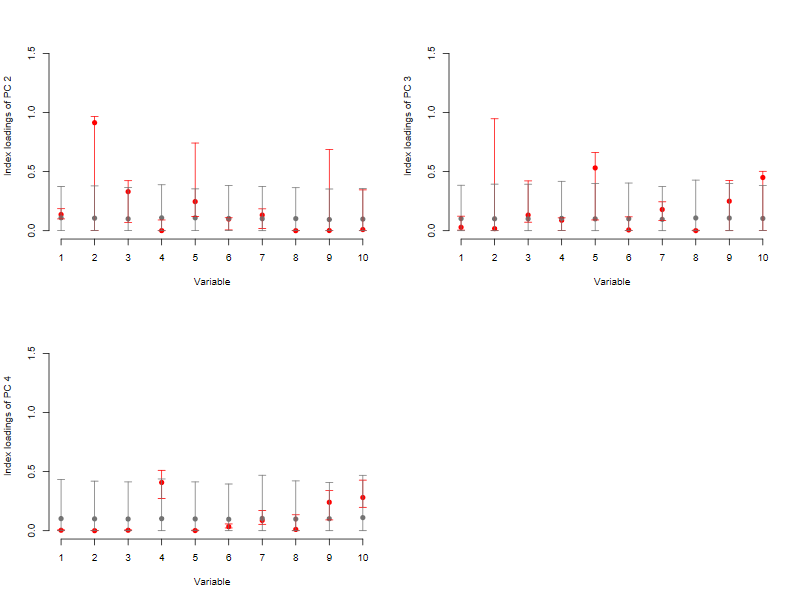

In [37]:
# Perform PCA
set.seed(42)
results <- PCAtest(num_data,
                  nperm = 1000,
                  nboot = 1000,
                  alpha = 0.05,
                  #scale = FALSE,
                  counter = FALSE,
                  plot = TRUE
                  )

In [38]:
loan_pca <- prcomp(loan_scaled, scale = FALSE, center = TRUE)

In [39]:
library(factoextra)
# Kaiser Criterion
get_eigenvalue(loan_pca)
# We should pick five principal components, since the eigenvalues are over 1

In [40]:
# Create the PCA recipe
pca_prep <- recipe(status~., data =data) |> 
  step_normalize(all_numeric_predictors()) |> 
  step_pca(all_numeric_predictors(), num_comp = 5) |> 
  prep()

In [41]:
pca_prep


── Recipe ─────────────────────────────────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 31

── Training information 
Training data contained 50000 data points and no incomplete rows.

── Operations 
• Centering and scaling for: loan_amount, rate_of_interest, interest_rate_spread, ... | Trained
• PCA extraction with: loan_amount, rate_of_interest, interest_rate_spread, ... | Trained

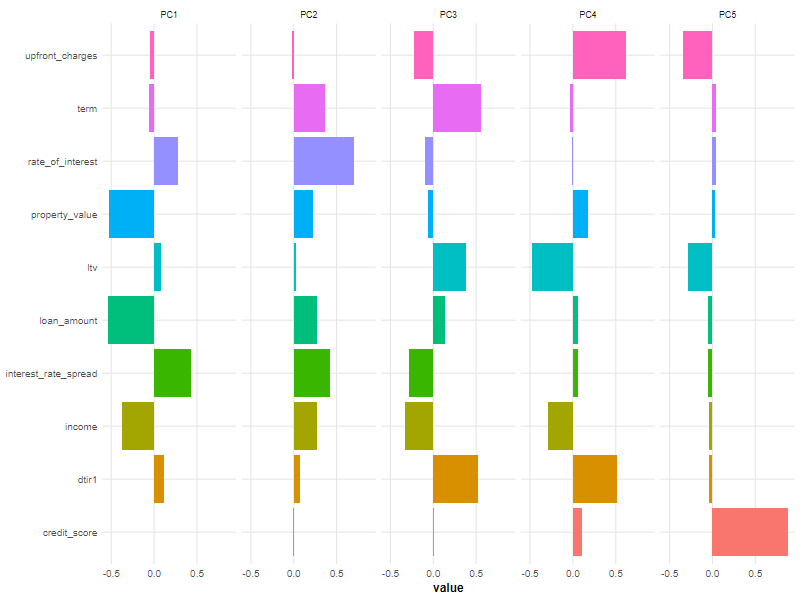

In [42]:
# Visualize the contribution of variables to the components

tidied_pca <- tidy(pca_prep, 2)
tidied_pca |> 
  filter(component %in% paste0("PC", 1:5)) |> 
  mutate(component = fct_inorder(component)) |> 
  ggplot(aes(value, terms, fill = terms)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~component, nrow = 1)+
  labs(y = NULL)

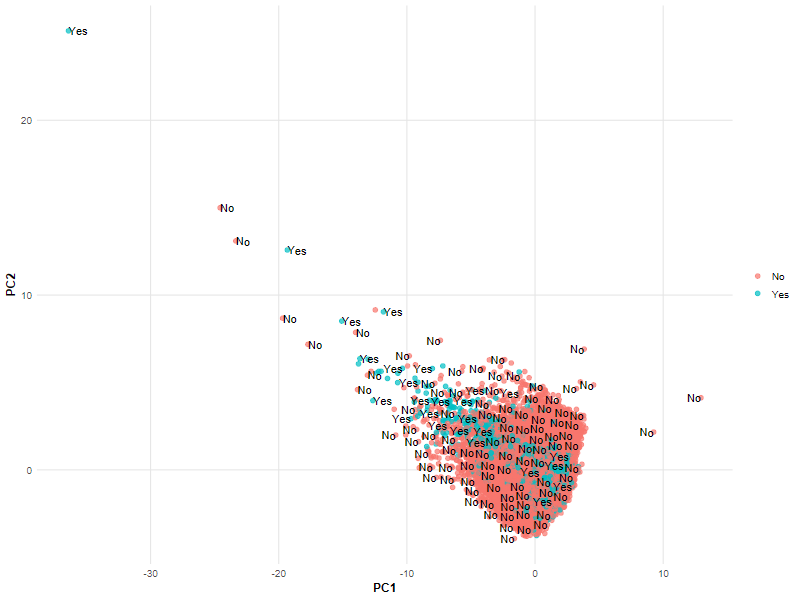

In [43]:
juice(pca_prep) %>%
  ggplot(aes(PC1, PC2, label = status)) +
  geom_point(aes(color = status), alpha = 0.7, size = 2) +
  geom_text(check_overlap = TRUE, hjust = "inward", family = "IBMPlexSans") +
  labs(color = NULL)

In [44]:
tidied_pca %>% 
  pivot_wider(names_from = component, values_from = value) %>% 
  select(-id) %>% 
  select(terms, PC1, PC2, PC3, PC4, PC5) -> standard_loadings

standard_loadings %>% 
  as.data.frame() -> standard_loadings

rownames(standard_loadings) <- standard_loadings$terms
standard_loadings <- standard_loadings %>% 
  select(-terms) 

sparse_loading_subset <- loadings_sparse[, 1:5]
colnames(sparse_loading_subset) <- paste0("SPC", 1:5)

# Combine both loadings
all_loadings <- cbind(standard_loadings, sparse_loading_subset)


## Standard vs Sparse PCA Comparison

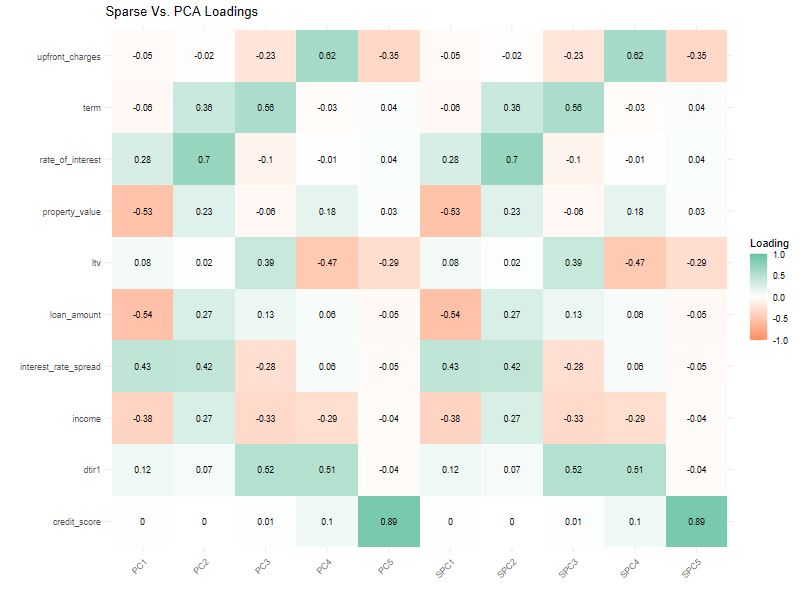

In [45]:
long_data <- all_loadings %>% 
  rownames_to_column(var = "terms") %>% 
  pivot_longer(cols = -terms, names_to = "Feature", values_to = "Loading")

ggplot(long_data, aes(Feature, terms, fill = Loading)) +
  geom_tile() +
  geom_text(aes(label = round(Loading, 2)), size = 3) +
  scale_fill_gradient2(low = "#fc8d62", mid = "white", high = "#66c2a5", 
  midpoint = 0, limits = c(-1, 1)) +
  labs(title = "Sparse Vs. PCA Loadings",
  x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

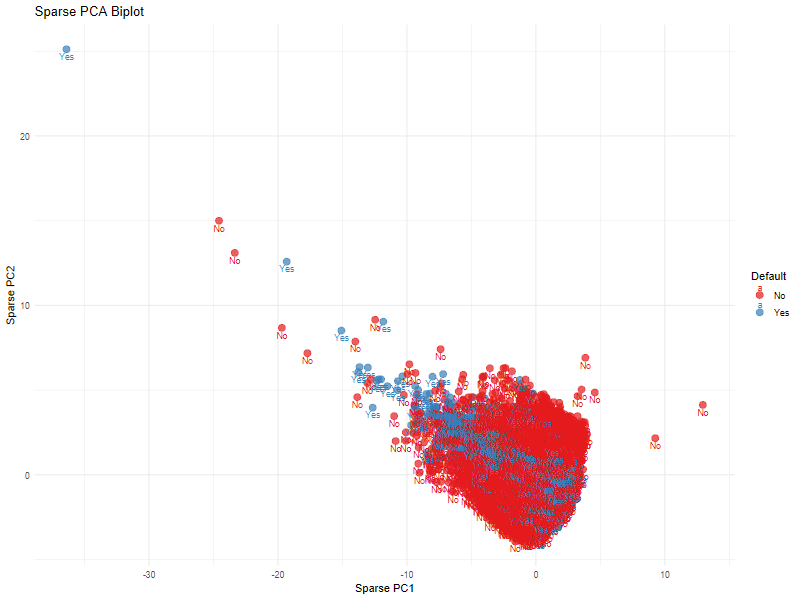

In [46]:
# Interactive Biplots for Sparse PCA
spca_scores <- loan_scaled %*% loadings_sparse[, 1:2]
biplot_data <- data.frame(
  PC1 = spca_scores[, 1],
  PC2 = spca_scores[, 2],
  Default = as.factor(data$status)
)

ggplot(biplot_data, aes(PC1, PC2, color = Default)) +
  geom_point(size = 3, alpha = 0.7) +
  geom_text(aes(label = Default), vjust = 1.5, size = 3) +
  scale_color_manual(values = c("#E41A1C", "#377EB8", "#4DAF4A")) +
  labs(title = "Sparse PCA Biplot",
       x = "Sparse PC1",
       y = "Sparse PC2") +
  theme_minimal()

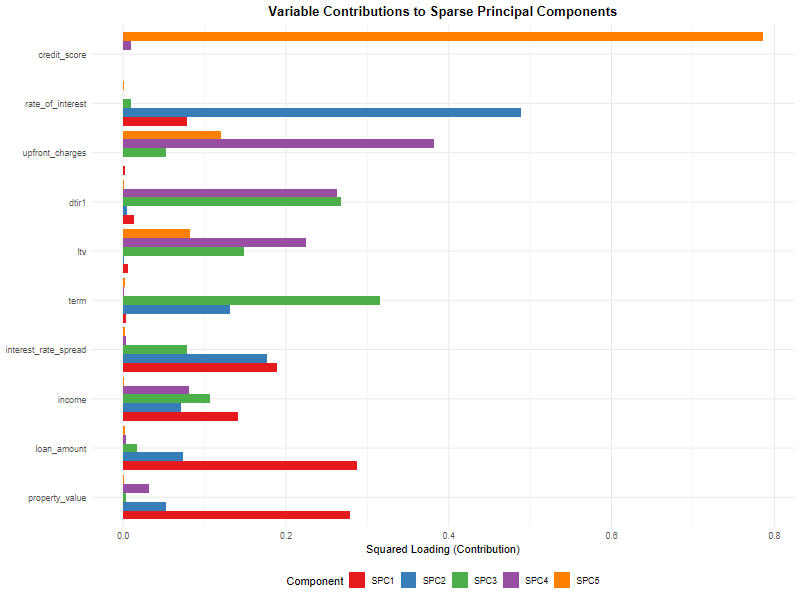

In [47]:
# Calculate variable contributions (squared loadings)
contrib_df <- as.data.frame(loadings_sparse^2)
colnames(contrib_df) <- paste0("SPC", 1:ncol(contrib_df))
contrib_df$Variable <- rownames(contrib_df)

contrib_long <- pivot_longer(contrib_df, 
                            cols = starts_with("SPC"), 
                            names_to = "Component", 
                            values_to = "Contribution")

# Sort by contribution within each component
contrib_long <- contrib_long %>%
  group_by(Component) %>%
  arrange(desc(Contribution)) %>%
  ungroup()

# Keep only non-zero contributions for clarity
contrib_long <- contrib_long %>% filter(Contribution > 0)

# Create a bar chart of variable contributions
ggplot(contrib_long, aes(x = reorder(Variable, Contribution), y = Contribution, fill = Component)) +
  geom_bar(stat = "identity", position = "dodge") +
  coord_flip() +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Variable Contributions to Sparse Principal Components",
       x = NULL,
       y = "Squared Loading (Contribution)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom")

# 6. Feature Importance and Selection

## Prep data

In [48]:
# Create initial train/test split (70/30)
loan_split <- initial_split(data, prop = 0.7, strata = status)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

# Create cross-validation folds for tuning
loan_folds <- vfold_cv(loan_train, v = 5, strata = status)

# Display split information
split_info <- tribble(
  ~Dataset, ~Rows, ~`status (Yes)`, ~`status (No)`, ~`status Rate (%)`,
  "Original", nrow(data), 
  sum(data$status == "Yes"), 
  sum(data$status == "No"),
  mean(data$status == "Yes") * 100,
  
  "Training", nrow(loan_train), 
  sum(loan_train$status == "Yes"), 
  sum(loan_train$status == "No"),
  mean(loan_train$status == "Yes") * 100,
  
  "Testing", nrow(loan_test), 
  sum(loan_test$status == "Yes"), 
  sum(loan_test$status == "No"),
  mean(loan_test$status == "Yes") * 100
)

kable(split_info, caption = "Data Split Overview") 



Table: Data Split Overview

|Dataset  |  Rows| status (Yes)| status (No)| status Rate (%)|
|:--------|-----:|------------:|-----------:|---------------:|
|Original | 50000|        12322|       37678|        24.64400|
|Training | 34999|         8625|       26374|        24.64356|
|Testing  | 15001|         3697|       11304|        24.64502|

In [49]:
# Define preprocessing steps
loan_recipe <- recipe(status ~ ., data = loan_train) %>%
  
  # Handle missing values
  step_impute_knn(all_predictors(), neighbors = 5) %>%
  # Group Rare categories into other category
  step_other(all_nominal_predictors(), threshold = 0.2) %>% 
  # Treat new categories as new 
  step_novel(all_nominal_predictors()) %>% 
  
  # Create dummy variables for categorical predictors
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero variance predictors
  step_nzv(all_predictors()) %>%
  
  # Remove highly correlated predictors
  step_corr(all_numeric_predictors(), threshold = 0.7) %>%
  
  # Normalize numeric predictors
  step_normalize(all_numeric_predictors()) %>%
  
  # Handle class imbalance using SMOTE
  themis::step_smote(status, over_ratio = 0.8)

# Print the recipe
loan_recipe


── Recipe ─────────────────────────────────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 31

── Operations 
• K-nearest neighbor imputation for: all_predictors()
• Collapsing factor levels for: all_nominal_predictors()
• Novel factor level assignment for: all_nominal_predictors()
• Dummy variables from: all_nominal_predictors()
• Sparse, unbalanced variable filter on: all_predictors()
• Correlation filter on: all_numeric_predictors()
• Centering and scaling for: all_numeric_predictors()
• SMOTE based on: status

In [50]:
# Prepare the recipe
loan_prep <- prep(loan_recipe)

# View the processed training data
loan_train_processed <- juice(loan_prep)

# Summarize the processed data
loan_train_processed %>%
  glimpse()

# Count the number of predictors after preprocessing
num_predictors <- ncol(loan_train_processed) - 1
cat("Number of predictors after preprocessing:", num_predictors)

Rows: 47,473
Columns: 30
$ loan_amount                       <dbl> 2.00965674, 2.06438827, 0.09405334, 1.40760996, -0.78165107, 0.…
$ rate_of_interest                  <dbl> -0.1227423, -0.1418235, 0.8313179, -1.6969415, 0.3542878, -0.83…
$ interest_rate_spread              <dbl> -0.3222674045, -0.6350655053, 1.1101378553, -1.6583003724, 1.14…
$ upfront_charges                   <dbl> -1.10899543, -0.98317511, 0.63208576, -0.88795974, 0.71922484, …
$ term                              <dbl> 0.4245912, 0.4245912, 0.4245912, 0.4245912, 0.4245912, 0.424591…
$ income                            <dbl> 0.54648237, 0.49140539, -0.27967232, 0.86776475, -0.46326225, -…
$ credit_score                      <dbl> -0.84545327, 1.41821134, 1.38365158, -0.10241832, -1.43296928, …
$ ltv                               <dbl> 1.0433059, -0.1396639, 0.3498814, 0.3118643, 0.6994371, 1.11834…
$ dtir1                             <dbl> 0.09979829, 0.20067979, 0.60420579, -0.70725371, 0.80596879, 0.…
$ loan_limit

## Machine Learning-Based Feature Importance

### Random Forest

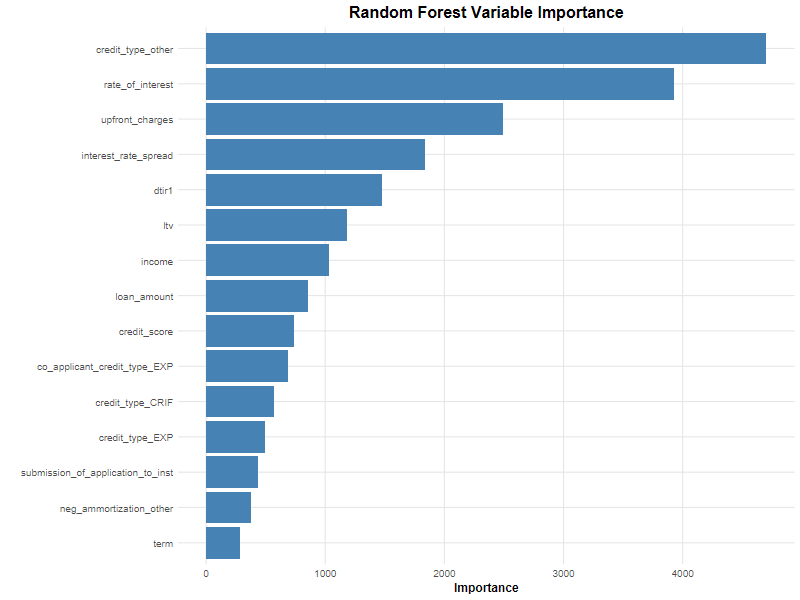

In [51]:
library(vip)
set.seed(42)

# Set up a random forest model
rf_model <- rand_forest() %>%
  set_engine("randomForest") %>%
  set_mode("classification") 

rf_wflow <- workflow() %>% 
  add_recipe(loan_recipe) %>% 
  add_model(rf_model)

rf_wflow %>% 
  fit(data = loan_train) -> rf_fit

fitted_rf <- extract_fit_parsnip(rf_fit)
vip(fitted_rf, num_features = 15, geom = "col", aesthetics = list(fill = "steelblue")) +
  labs(title = "Random Forest Variable Importance")

### 5.2 XGBoost Feature Importance

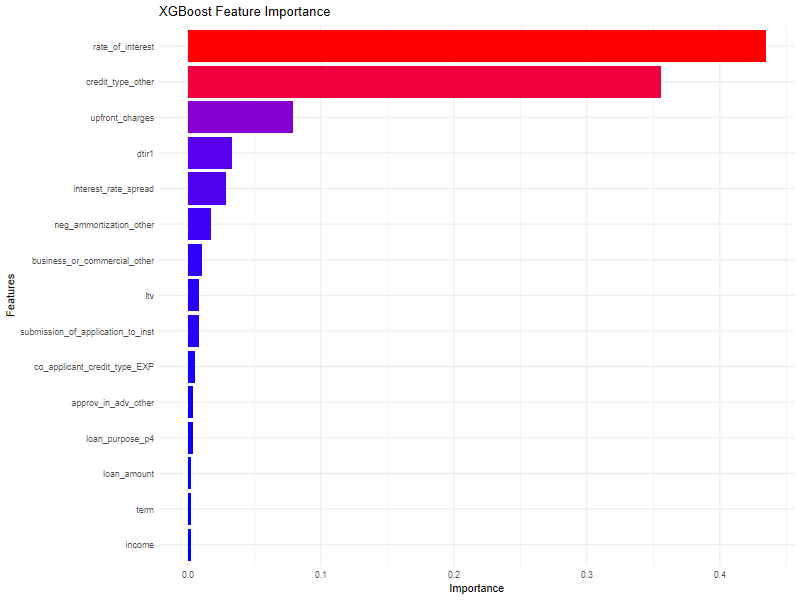

In [52]:
library(xgboost)

set.seed(42)
xgb_model <- boost_tree() %>%
  set_engine("xgboost") %>%
  set_mode("classification")

xgb_wflow <- workflow() %>%
  add_recipe(loan_recipe) %>%
  add_model(xgb_model)

xgb_fit <- xgb_wflow %>% 
  fit(data = loan_train)

fitted_xgb <- extract_fit_parsnip(xgb_fit)

feature_names <- fitted_xgb$fit$feature_names

xgb_importance <- xgb.importance(
  model = fitted_xgb$fit,
  feature_names = feature_names  
)


xgb_importance_df <- xgb_importance %>%
  slice_max(order_by = Gain, n = 15) %>% 
  mutate(Feature = factor(Feature, levels = rev(Feature))) 


ggplot(xgb_importance_df, aes(x = Feature, y = Gain, fill = Gain)) +
  geom_col(show.legend = FALSE) +
  scale_fill_gradient(low = "blue", high = "red") +
  coord_flip() +  
  labs(title = "XGBoost Feature Importance", x = "Features", y = "Importance") +
  theme_minimal()


# Recursive Feature Elimination
RFE is a feature selection method that recursively removes the weakest feature(s) until the specified number of features is reached.

In [53]:
library(caret)
library(doParallel)
# Set up parallel processing for faster computation
registerDoParallel(cores = 3)

# Define control parameters for RFE
rfe_control <- rfeControl(
  functions = nbFuncs,  #Use Naiverace
  method = "cv",        # Cross-validation
  number = 5,           # 5-fold CV
  verbose = FALSE,
  allowParallel = TRUE
)

# Run RFE
set.seed(123)
rfe_result <- rfe(
  x = loan_train_processed %>% select(-status),
  y = loan_train_processed$status,
  sizes = c(1:10, 15, 20),  
  rfeControl = rfe_control
)

stopImplicitCluster()

Loading required package: lattice
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel



Recursive feature selection

Outer resampling method: Cross-Validated (5 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD  KappaSD Selected
         1   0.7426 0.4467   0.002641 0.006019         
         2   0.7445 0.4512   0.002587 0.005897         
         3   0.7551 0.4752   0.002816 0.006395         
         4   0.7599 0.4861   0.005280 0.011963         
         5   0.7644 0.4963   0.002512 0.005658         
         6   0.7724 0.5145   0.002032 0.004635         
         7   0.7762 0.5238   0.003251 0.007075         
         8   0.7781 0.5294   0.003569 0.007591         
         9   0.7870 0.5510   0.004140 0.008858         
        10   0.7886 0.5521   0.003338 0.007497         
        15   0.7951 0.5664   0.004262 0.009417         
        20   0.8053 0.5883   0.003957 0.008725         
        29   0.8295 0.6470   0.009380 0.024108        *

The top 5 variables (out of 29):
   credit_type_other, income, co_applicant_credit_type_EXP

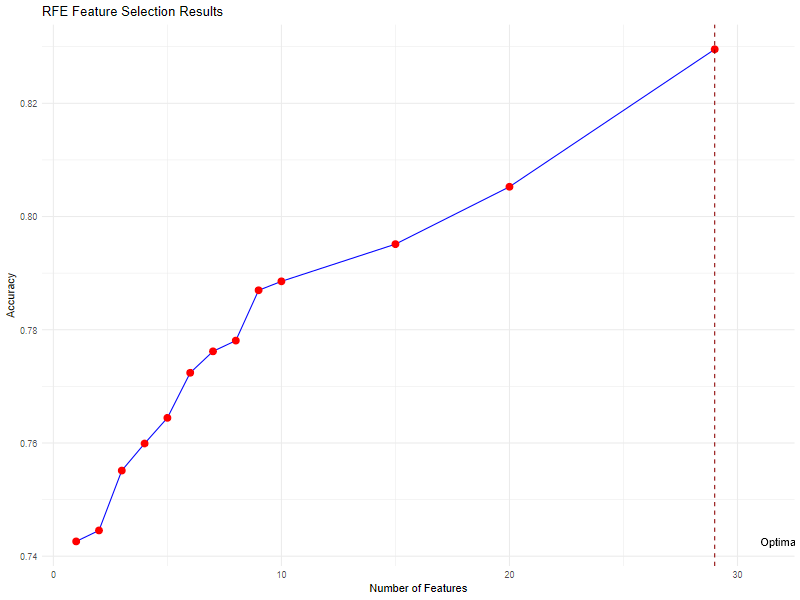

In [54]:
# Print RFE results
print(rfe_result)

# Plot the results
plot(rfe_result, type = c("g", "o"))

# Get the optimal features
optimal_vars <- predictors(rfe_result)
cat("Optimal features selected by RFE:", paste(optimal_vars, collapse = ", "))

# Plot the selected feature set performance
ggplot(data = data.frame(
  Variables = rfe_result$results$Variables,
  Accuracy = rfe_result$results$Accuracy
)) +
  geom_line(aes(x = Variables, y = Accuracy), color = "blue") +
  geom_point(aes(x = Variables, y = Accuracy), color = "red", size = 3) +
  geom_vline(xintercept = rfe_result$optsize, linetype = "dashed", color = "darkred") +
  annotate("text", x = rfe_result$optsize + 2, y = min(rfe_result$results$Accuracy), 
           label = paste("Optimal size:", rfe_result$optsize), hjust = 0) +
  labs(title = "RFE Feature Selection Results",
       x = "Number of Features",
       y = "Accuracy") +
  theme_minimal()

## Lasso Regression

Warning message:
In select_best(.) :
  No value of `metric` was given; "roc_auc" will be used.


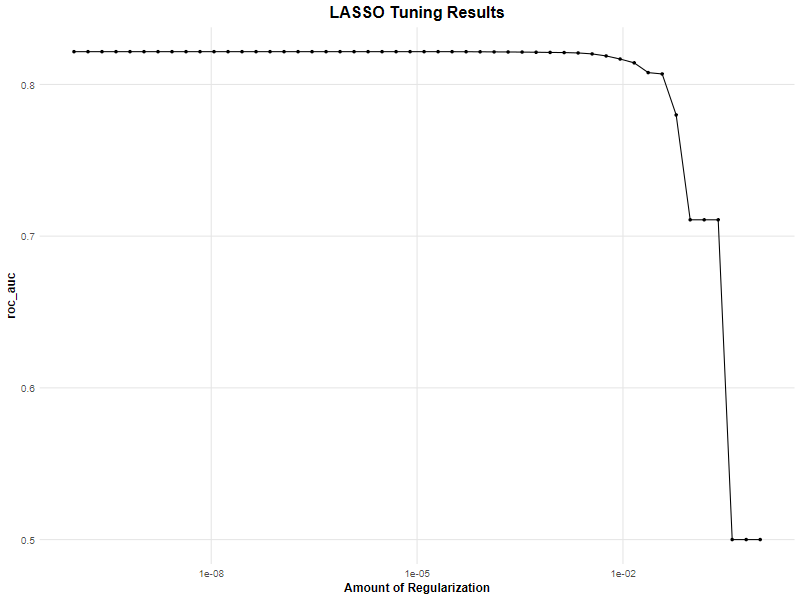

In [55]:
doParallel::stopImplicitCluster()

set.seed(123)
lasso_spec <- logistic_reg(penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

# Set up the workflow
lasso_wf <- workflow() %>%
  add_recipe(loan_recipe) %>% 
  add_model(lasso_spec)

# Set up grid of lambda values
lambda_grid <- grid_regular(penalty(), levels = 50)

# Set up resampling
folds <- vfold_cv(loan_train, v = 5, strata = status)

# Tune LASSO model
lasso_tune <- tune_grid(
  lasso_wf,
  resamples = folds,
  grid = lambda_grid,
  metrics = metric_set(roc_auc),
  control = control_grid(allow_par = FALSE)
)


# Get best lambda
best_lambda <- lasso_tune %>%
  select_best()

# Finalize workflow and fit model
lasso_final <- lasso_wf %>%
  finalize_workflow(best_lambda) %>%
  fit(data = loan_train)

# Extract lasso coefficients
lasso_coefs <- lasso_final %>%
  extract_fit_parsnip() %>%
  tidy() %>%
  filter(estimate != 0, term != "(Intercept)") %>%
  arrange(desc(abs(estimate)))

# Visualize LASSO coefficients
lasso_coefs %>%
  mutate(term = str_replace_all(term, "loan_purpose_", "Purpose: ")) %>%
  slice_head(n = 20) %>%
  ggplot(aes(x = reorder(term, abs(estimate)), y = estimate, fill = estimate > 0)) +
  geom_col() +
  scale_fill_manual(values = c("red", "blue"), labels = c("Negative", "Positive")) +
  coord_flip() +
  labs(title = "Top 20 LASSO Coefficients",
       x = "Features",
       y = "Coefficient Estimate",
       fill = "Direction") +
  theme_minimal()

# Plot the tuning results
autoplot(lasso_tune) +
  labs(title = "LASSO Tuning Results")



NULL


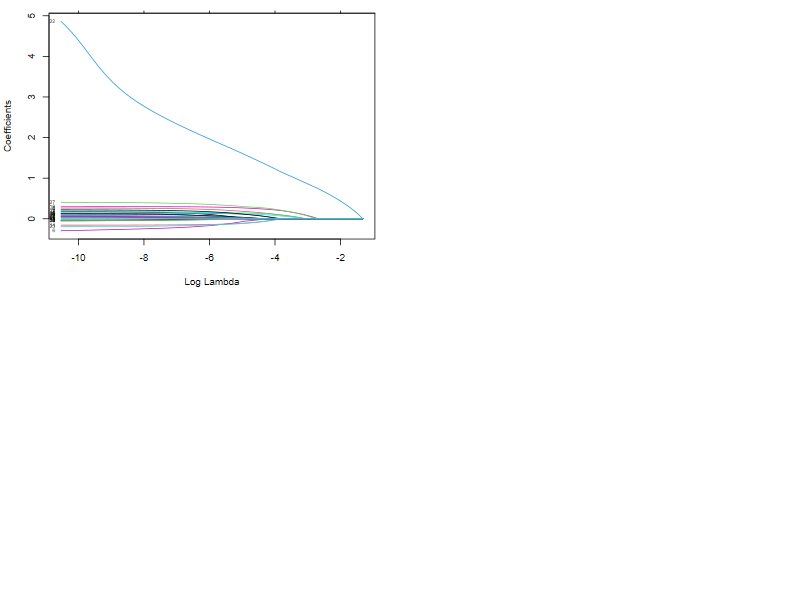

In [56]:
# Get non-zero coefficients across different lambda values
lasso_model <- extract_fit_parsnip(lasso_final)$fit
lasso_cv <- cv.glmnet(x = as.matrix(loan_train_processed %>% select(-status)),
                      y = loan_train_processed$status,
                      alpha = 1,
                      family = "binomial")

# Plot the coefficient path
print(plot(lasso_model, "lambda", label = TRUE))

## Elastic Net


❯  Generating a set of 5 initial parameter results
✓ Initialization complete

i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussia

Warning message:
In select_best(.) :
  No value of `metric` was given; "roc_auc" will be used.


                                term      estimate
1                  credit_type_other  2.460186e-02
2                   credit_type_CRIF -9.960192e-03
3       co_applicant_credit_type_EXP  9.693926e-03
4                    credit_type_EXP -9.119675e-03
5  submission_of_application_to_inst  8.890427e-03
6            neg_ammortization_other  8.842938e-03
7                                ltv  6.314134e-03
8                              dtir1  5.430775e-03
9       business_or_commercial_other  5.251080e-03
10              interest_rate_spread  4.673723e-03
11                  rate_of_interest  4.378805e-03
12                            income -4.267889e-03
13          gender_Sex.Not.Available  3.753012e-03
14               approv_in_adv_other -3.553462e-03
15                  loan_limit_other  3.422485e-03
16                      region_south  2.681073e-03
17                       loan_amount -2.502296e-03
18                       gender_Male  1.656637e-03
19                         age_

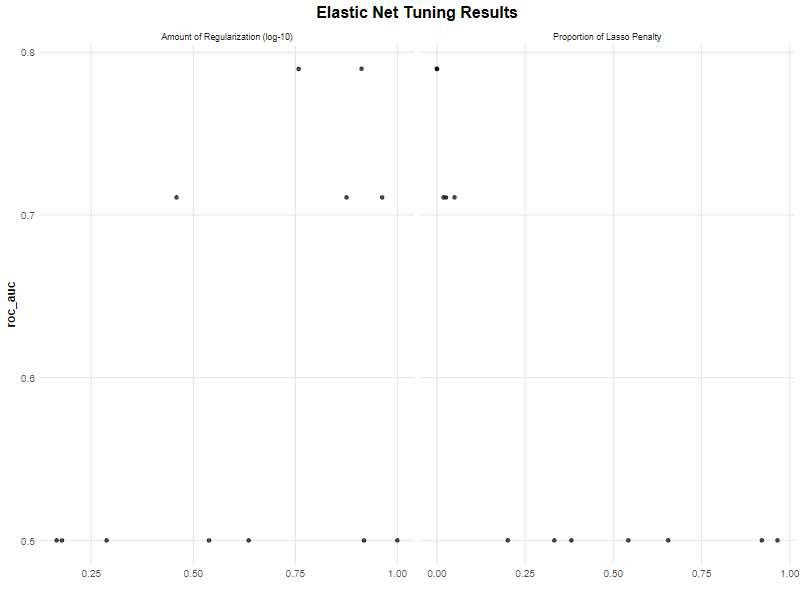

In [57]:
library(doParallel)
cl <- makeCluster(parallel::detectCores() - 1)
registerDoParallel(cl)

set.seed(42)
enet_spec <- logistic_reg(penalty = tune(), mixture = tune()) %>%
  set_engine("glmnet")

enet_wf <- workflow() %>%
  add_model(enet_spec) %>%
  add_recipe(loan_recipe)

enet_tune <- enet_wf %>%
  tune_bayes(
    resamples = folds,
    param_info = parameters(penalty(range = c(1e-4, 1)), mixture(range = c(0, 1))),  
    metrics = metric_set(roc_auc),
    iter = 20,  
    initial = 5,  
    control = control_bayes(no_improve = 5, verbose = TRUE)  
  )

autoplot(enet_tune) +
  labs(title = "Elastic Net Tuning Results")

best_enet <- enet_tune %>%
  select_best()

# Finalize workflow and fit model
enet_final <- enet_wf %>%
  finalize_workflow(best_enet) %>%
  fit(data = loan_train)

# Extract Elastic Net coefficients using direct access to model object
model_fit <- extract_fit_parsnip(enet_final)
glmnet_model <- model_fit$fit

# Get coefficients for the specific lambda value
coef_matrix <- coef(glmnet_model, s = best_enet$penalty)
# Convert sparse matrix to data frame
coef_df <- data.frame(
  term = rownames(coef_matrix),
  estimate = as.numeric(coef_matrix)
) %>%
  filter(estimate != 0, term != "(Intercept)") %>%
  arrange(desc(abs(estimate)))

# Display the top coefficients
print(coef_df)

stopCluster(cl)

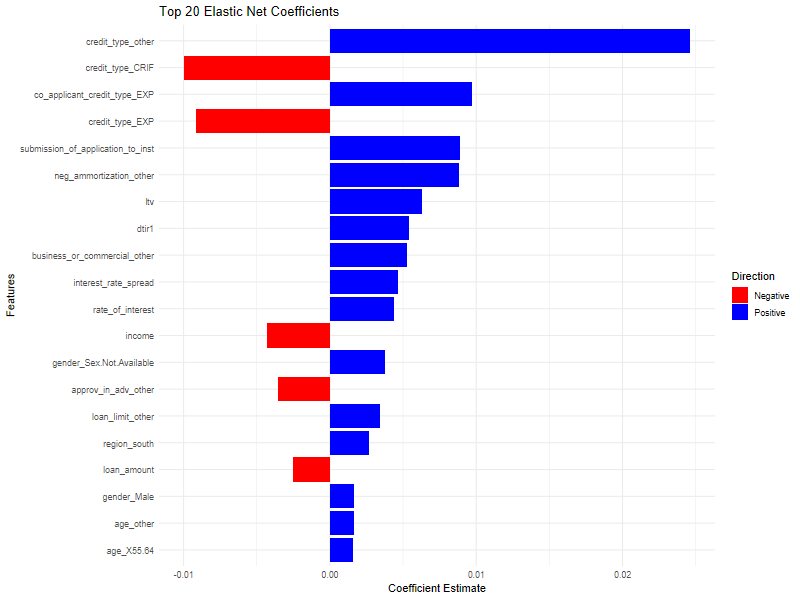

In [58]:
coef_df %>%
  slice_head(n = 20) %>%
  ggplot(aes(x = reorder(term, abs(estimate)), y = estimate, fill = estimate > 0)) +
  geom_col() +
  scale_fill_manual(values = c("red", "blue"), labels = c("Negative", "Positive")) +
  coord_flip() +
  labs(title = "Top 20 Elastic Net Coefficients",
       x = "Features",
       y = "Coefficient Estimate",
       fill = "Direction") +
  theme_minimal()

## Compare the different feature selection techniques



Table: Top 10 Features from Each Method

|RandomForest                 |XGBoost                           |RFE                               |LASSO                             |ElasticNet                        |
|:----------------------------|:---------------------------------|:---------------------------------|:---------------------------------|:---------------------------------|
|credit_type_other            |rate_of_interest                  |credit_type_other                 |credit_type_other                 |credit_type_other                 |
|rate_of_interest             |credit_type_other                 |income                            |submission_of_application_to_inst |credit_type_CRIF                  |
|upfront_charges              |upfront_charges                   |co_applicant_credit_type_EXP      |neg_ammortization_other           |co_applicant_credit_type_EXP      |
|interest_rate_spread         |dtir1                             |upfront_charges                

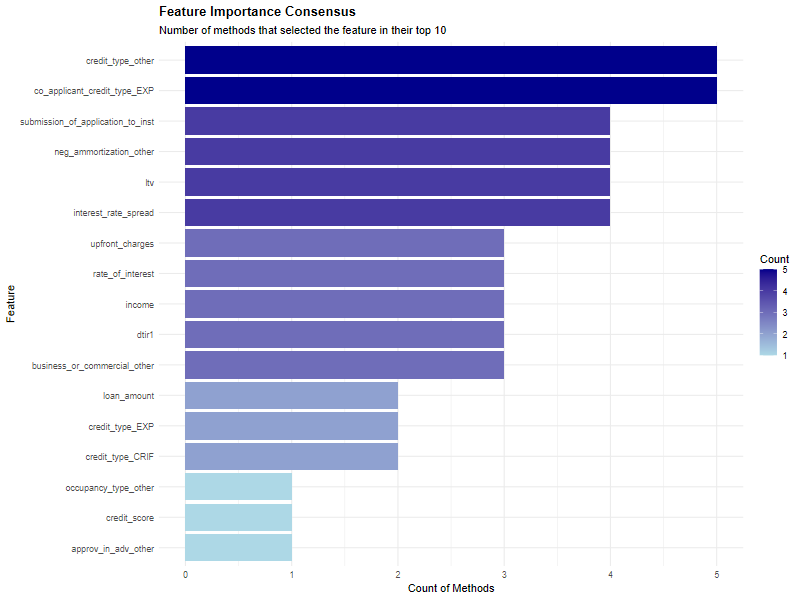

In [59]:
top_xgb <- xgb_importance %>% 
  slice_head(n = 10) %>% 
  pull(Feature)

top_rfe <- optimal_vars[1:min(10, length(optimal_vars))]
top_lasso <- lasso_coefs %>%
  slice_head(n = 10) %>%
  pull(term)

top_enet <- coef_df %>%
  slice_head(n = 10) %>%
  pull(term)

top_rf <- vip::vi(fitted_rf) %>% 
  arrange(desc(Importance)) %>%
  slice_head(n = 10) %>% 
  pull(Variable)

comparison_df <- data.frame(
  RandomForest = c(top_rf, rep(NA, 10 - length(top_rf))),
  XGBoost = c(top_xgb, rep(NA, 10 - length(top_xgb))),
  RFE = c(top_rfe, rep(NA, 10 - length(top_rfe))),
  LASSO = c(top_lasso, rep(NA, 10 - length(top_lasso))),
  ElasticNet = c(top_enet, rep(NA, 10 - length(top_enet)))
)
kable(comparison_df, caption = "Top 10 Features from Each Method") %>% 
  print()


count_feature_importance <- function(feature, methods_list) {
  sum(sapply(methods_list, function(method) feature %in% method))
}

all_features <- unique(c(top_rf, top_xgb, 
  top_rfe, top_lasso, top_enet))
all_features <- all_features[!is.na(all_features)]


feature_counts <- sapply(all_features, function(feat) {
count_feature_importance(feat, list(top_rf, top_xgb, 
              top_rfe, top_lasso, top_enet))
})


feature_counts_df <- data.frame(
Feature = names(feature_counts),
Count = as.numeric(feature_counts)
)

feature_counts_df %>%
arrange(desc(Count)) %>%
slice_head(n = 20) %>%
ggplot(aes(x = reorder(Feature, Count), y = Count, fill = Count)) +
geom_bar(stat = "identity") +
scale_fill_gradient(low = "lightblue", high = "darkblue") +
coord_flip() +
labs(title = "Feature Importance Consensus",
subtitle = "Number of methods that selected the feature in their top 10",
x = "Feature",
y = "Count of Methods") +
theme_minimal() +
theme(plot.title = element_text(face ="bold"))


Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases


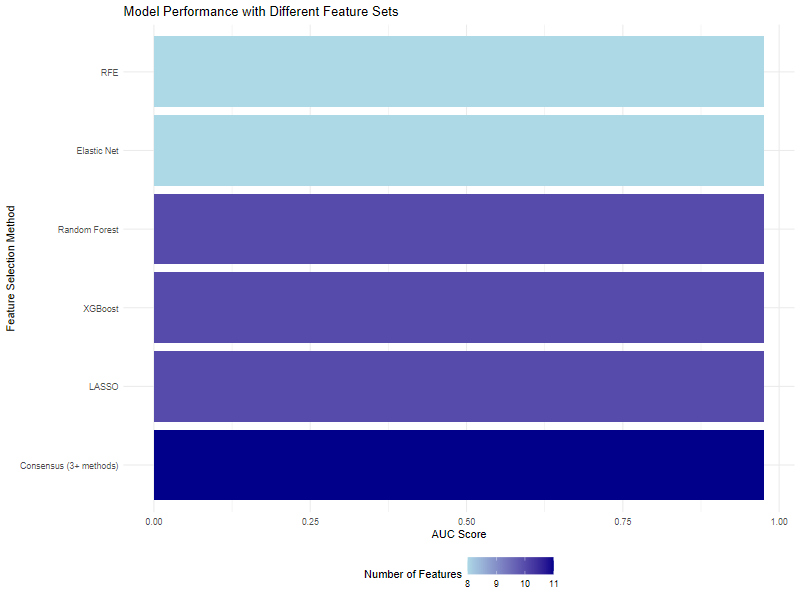

In [61]:
# How do these models perform based on the  selected features?
# Define a function to train and evaluate a model
evaluate_feature_set <- function(features, name) {
  
  # Prep the recipe
  feature_prep <- prep(loan_recipe)
  train_processed <- bake(feature_prep, new_data = loan_train)
  test_processed <- bake(feature_prep, new_data = loan_test)
  
  # Train a random forest model
  rf_model <- rand_forest() %>%
    set_engine("randomForest") %>%
    set_mode("classification") %>%
    fit(status ~ ., data = train_processed)
  
  # Make predictions
  preds <- predict(rf_model, test_processed, type = "prob") %>%
    bind_cols(test_processed) %>%
    select(status, .pred_Yes)
  
  # Calculate performance metrics
  roc_obj <- roc(preds$status, preds$.pred_Yes)
  auc_value <- auc(roc_obj)
  
  # Return results
  return(list(
    name = name,
    auc = auc_value,
    roc = roc_obj,
    features = features
  ))
}

get_base_features <- function(terms) {
  base_features <- unique(sapply(terms, function(term) {
    
    # Special case handling
    term <- gsub("submission_of_application_to_inst", "submission_of_application", term)
    
    # Remove common suffixes
    term <- gsub("_(other|EXP|CRIF|to_inst|to)$", "", term)
    
    # Remove trailing underscores with categories (like loan_purpose_auto -> loan_purpose)
    term <- gsub("_(auto|p4|mortgage|south|Male|X[0-9.]+)$", "", term)
    
    return(term)
  }))
  
  return(base_features)
}


features <- c("credit_type_other", "rate_of_interest", "upfront_charges", "interest_rate_spread",
              "dtir1", "ltv", "income", "property_value", "credit_score", 
              "co_applicant_credit_type_EXP", "neg_ammortization_other", 
              "submission_of_application_to_inst", "business_or_commercial_other", 
              "approv_in_adv_other", "credit_type_CRIF", "credit_type_EXP", 
              "occupancy_type_other", "loan_limit_other", "loan_purpose_auto",
              "loan_purpose_p4", "region_south", 
              "gender_Male", "age_X55.64")

# Get the base features for the top models

rf_features <- get_base_features(top_rf)
xgb_features <- get_base_features(top_xgb)
rfe_features <- get_base_features(top_rfe)
lasso_features <- get_base_features(top_lasso)
enet_features <- get_base_features(top_enet)

# Get consensus features (features that appear in multiple methods)
all_base_features <- unique(c(rf_features, xgb_features, rfe_features, 
  get_base_features(top_lasso), get_base_features(top_enet)))
all_base_features <- all_base_features[!is.na(all_base_features)]


feature_counts <- sapply(all_base_features, function(feat) {
  sum(
  feat %in% rf_features,
  feat %in% xgb_features,
  feat %in% rfe_features,
  feat %in% get_base_features(top_lasso),
  feat %in% get_base_features(top_enet))
  })
  
consensus_features <- names(feature_counts[feature_counts >= 3])

# Evaluate each feature set
set.seed(42)
results_list <- list(
evaluate_feature_set(rf_features, "Random Forest"),
evaluate_feature_set(xgb_features, "XGBoost"),
evaluate_feature_set(rfe_features, "RFE"),
evaluate_feature_set(get_base_features(top_lasso), "LASSO"),
evaluate_feature_set(get_base_features(top_enet), "Elastic Net"),
evaluate_feature_set(consensus_features, "Consensus (3+ methods)")
)

# Plot ROC curves
colors <- c("blue", "green", "purple", "orange", "brown", "black")
plot(results_list[[1]]$roc, col = colors[1], main = "ROC Curves for Different Feature Sets")
for(i in 2:length(results_list)) {
lines(results_list[[i]]$roc, col = colors[i])
}
legend("bottomright", 
legend = sapply(results_list, function(r) paste0(r$name, " (AUC = ", round(r$auc, 3), ")")),
col = colors,
lwd = 2)
  
# Compare AUC values
auc_df <- data.frame(
  Method = sapply(results_list, function(r) r$name),
  AUC = sapply(results_list, function(r) r$auc),
  Features = sapply(results_list, function(r) length(r$features))
)

# Plot AUC comparison
auc_df %>%
  ggplot(aes(x = reorder(Method, AUC), y = AUC, fill = Features)) +
  geom_bar(stat = "identity") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  coord_flip() +
  labs(title = "Model Performance with Different Feature Sets",
       x = "Feature Selection Method",
       y = "AUC Score",
       fill = "Number of Features") +
  theme_minimal() +
  theme(legend.position = "bottom")



### Final Feature Selection

In [62]:
# Get the best performing feature set
best_method <- auc_df %>%
  arrange(desc(AUC)) %>%
  slice_head(n = 1)

best_method_name <- best_method$Method
best_method_idx <- which(sapply(results_list, function(r) r$name) == best_method_name)
best_features <- results_list[[best_method_idx]]$features

# Print the recommendation
cat("## Feature Selection Recommendation\n\n")
cat("Based on our analysis, the *", best_method_name, "* approach provides the best performance with an AUC of ", 
    round(best_method$AUC, 3), " using ", best_method$Features, " features.\n\n", sep = "")
cat("The recommended features for the loan default prediction model are:\n\n")
cat(paste("- ", best_features, collapse = "\n"))

final_recipe <- recipe(status ~ ., data = loan_train %>% 
  select(status, all_of(best_features))) %>% # Just join the previous recipe from here
  
  # Handle missing values
  step_impute_knn(all_predictors(), neighbors = 5) %>%
  # Group Rare categories into other category
  step_other(all_nominal_predictors(), threshold = 0.2) %>% 
  # Treat new categories as new 
  step_novel(all_nominal_predictors()) %>% 
  
  # Create dummy variables for categorical predictors
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero variance predictors
  step_nzv(all_predictors()) %>%
  
  # Remove highly correlated predictors
  step_corr(all_numeric_predictors(), threshold = 0.7) %>%
  
  # Normalize numeric predictors
  step_normalize(all_numeric_predictors()) %>%
  
  # Handle class imbalance using SMOTE
  themis::step_smote(status, over_ratio = 0.8)

loan_pca_recipe <- recipe(status ~ ., data = loan_train %>% 
    select(status, all_of(best_features))) %>% 
    step_impute_knn(all_predictors(), neighbors = 5) %>%
    step_other(all_nominal_predictors(), threshold = 0.2) %>% 
    step_novel(all_nominal_predictors()) %>% 
    step_dummy(all_nominal_predictors()) %>%
    step_nzv(all_predictors()) %>%
    step_corr(all_numeric_predictors(), threshold = 0.7) %>%
    step_normalize(all_numeric_predictors()) %>%
    step_pca(all_numeric_predictors(), num_comp = 5) %>% 
    themis::step_smote(status, over_ratio = 0.8)

## Feature Selection Recommendation

Based on our analysis, the *RFE* approach provides the best performance with an AUC of 0.976 using 8 features.

The recommended features for the loan default prediction model are:

-  credit_type
-  income
-  co_applicant_credit_type
-  upfront_charges
-  submission_of_application
-  interest_rate_spread
-  rate_of_interest
-  neg_ammortization

In [63]:
final_recipe


── Recipe ─────────────────────────────────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:   1
predictor: 8

── Operations 
• K-nearest neighbor imputation for: all_predictors()
• Collapsing factor levels for: all_nominal_predictors()
• Novel factor level assignment for: all_nominal_predictors()
• Dummy variables from: all_nominal_predictors()
• Sparse, unbalanced variable filter on: all_predictors()
• Correlation filter on: all_numeric_predictors()
• Centering and scaling for: all_numeric_predictors()
• SMOTE based on: status

In [64]:
# Define the models 
rf_spec <- rand_forest(
  mtry = tune(),
  trees = 500,
  min_n = tune()
) %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")


xgb_spec <- boost_tree(
  trees = 500,
  tree_depth = tune(),
  min_n = tune(),
  loss_reduction = tune(),
  sample_size = tune(),
  mtry = tune(),
  learn_rate = tune()
) %>%
  set_engine("xgboost") %>%
  set_mode("classification")

log_reg_spec <- logistic_reg(
  penalty = tune(),
  mixture = tune()
) %>%
  set_engine("glmnet") %>%
  set_mode("classification")

nnet_spec <-
  mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>%
  set_engine('nnet') %>%
  set_mode('classification')



## Hyperparameter Tuning
### Tune Race Anova

In [69]:
# Perform Hyperparameter tuning(Tune Race Anova) and fit the models
library(finetune)
cl <- makePSOCKcluster(detectCores() - 1)
registerDoParallel(cl)
loan_workflow <- workflow_set(
  preproc = list(loan_recipe, loan_pca_recipe),
  models = list(
    randomforest = rf_spec,
    xgboost = xgb_spec,
    logistic_regression = log_reg_spec,
    nnet = nnet_spec
  )
)

metrics <- metric_set(yardstick::accuracy, roc_auc, yardstick::sensitivity, yardstick::specificity, brier_class, yardstick::f_meas)
race_ctrl <- control_race(
  save_pred = TRUE,
  parallel_over = "everything",
  save_workflow = TRUE
)

race_results <- loan_workflow %>%
  workflow_map(
    seed = 42,
    fn = "tune_race_anova",
    resamples = loan_folds,
    grid = 10,
    metrics = metrics,
    control = race_ctrl
  )
stopCluster(cl)

i Creating pre-processing data to finalize unknown parameter: mtry
ℹ The workflow being saved contains a recipe, which is 5.72 Mb in memory. If this was ℹ not intentional,
please set the control setting `save_workflow = FALSE`.
ℹ The workflow being saved contains a recipe, which is 5.72 Mb in memory. If this was ℹ not intentional,
please set the control setting `save_workflow = FALSE`.
ℹ The workflow being saved contains a recipe, which is 5.72 Mb in memory. If this was ℹ not intentional,
please set the control setting `save_workflow = FALSE`.
i Creating pre-processing data to finalize unknown parameter: mtry
ℹ The workflow being saved contains a recipe, which is 5.72 Mb in memory. If this was ℹ not intentional,
please set the control setting `save_workflow = FALSE`.
ℹ The workflow being saved contains a recipe, which is 5.72 Mb in memory. If this was ℹ not intentional,
please set the control setting `save_workflow = FALSE`.
ℹ The workflow being saved contains a recipe, which is 5.72 M

In [70]:
race_results <- race_results %>% 
  mutate(wflow_id = gsub("recipe_1", "normal", wflow_id),
         wflow_id = gsub("recipe_2", "pca", wflow_id))


In [71]:
race_results

# A workflow set/tibble: 8 × 4
  wflow_id                   info             option    result   
  <chr>                      <list>           <list>    <list>   
1 normal_randomforest        <tibble [1 × 4]> <opts[4]> <race[+]>
2 normal_xgboost             <tibble [1 × 4]> <opts[4]> <race[+]>
3 normal_logistic_regression <tibble [1 × 4]> <opts[4]> <race[+]>
4 normal_nnet                <tibble [1 × 4]> <opts[4]> <race[+]>
5 pca_randomforest           <tibble [1 × 4]> <opts[4]> <race[+]>
6 pca_xgboost                <tibble [1 × 4]> <opts[4]> <race[+]>
7 pca_logistic_regression    <tibble [1 × 4]> <opts[4]> <race[+]>
8 pca_nnet                   <tibble [1 × 4]> <opts[4]> <race[+]>

In [72]:
# Rank the results based on the F1-score
race_results %>% 
  rank_results() %>% 
  filter(.metric == "f_meas") %>% 
  select(model, .config, f1_score = mean, rank)

# A tibble: 12 × 4
   model        .config               f1_score  rank
   <chr>        <chr>                    <dbl> <int>
 1 boost_tree   Preprocessor1_Model02    0.992     1
 2 boost_tree   Preprocessor1_Model03    0.991     2
 3 rand_forest  Preprocessor1_Model08    0.987     3
 4 rand_forest  Preprocessor1_Model05    0.987     4
 5 mlp          Preprocessor1_Model02    0.919     5
 6 logistic_reg Preprocessor1_Model06    0.914     6
 7 logistic_reg Preprocessor1_Model06    0.909     7
 8 boost_tree   Preprocessor1_Model09    0.908     8
 9 boost_tree   Preprocessor1_Model10    0.908     9
10 mlp          Preprocessor1_Model06    0.906    10
11 mlp          Preprocessor1_Model03    0.902    11
12 rand_forest  Preprocessor1_Model09    0.891    12

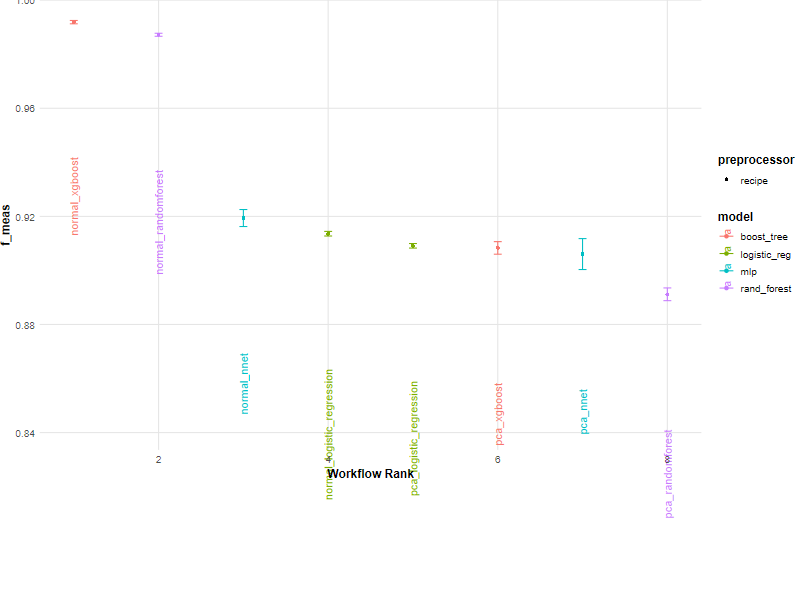

In [73]:
autoplot(race_results,
  rank_metric = "f_meas",
  metric = "f_meas",
  select_best = TRUE) +
  geom_text(aes(y = mean - 0.05, label = wflow_id), angle = 90, hjust = 1) +
  coord_cartesian(clip = "off") +
  theme(plot.margin = margin(b = 120)) 

In [74]:
# Extract all metrics and predictions
all_metrics <- collect_metrics(race_results)
all_predictions <- collect_predictions(race_results)
# 1. Overall Performance Comparison
overall_comparison <- race_results %>%
  collect_metrics() %>%
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    .groups = "drop"
  ) %>%
  arrange(wflow_id, mean_perf)

overall_comparison

# A tibble: 48 × 4
   wflow_id                   .metric     mean_perf sd_perf
   <chr>                      <chr>           <dbl>   <dbl>
 1 normal_logistic_regression brier_class     0.168      NA
 2 normal_logistic_regression specificity     0.422      NA
 3 normal_logistic_regression roc_auc         0.711      NA
 4 normal_logistic_regression accuracy        0.857      NA
 5 normal_logistic_regression f_meas          0.914      NA
 6 normal_logistic_regression sensitivity     1          NA
 7 normal_nnet                brier_class     0.129      NA
 8 normal_nnet                specificity     0.822      NA
 9 normal_nnet                accuracy        0.881      NA
10 normal_nnet                sensitivity     0.900      NA
# ℹ 38 more rows
# ℹ Use `print(n = ...)` to see more rows

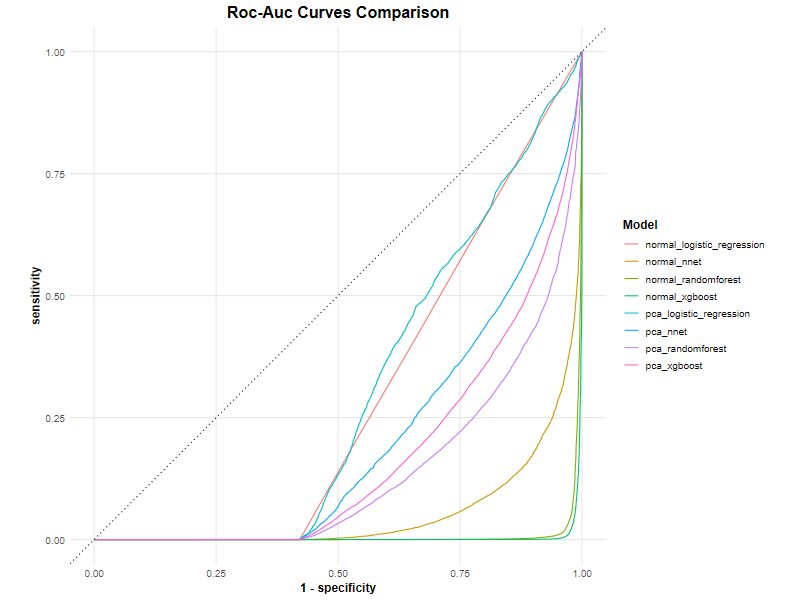

In [75]:
# 2. ROC Curves Comparison
roc_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  roc_curve(truth = status, .pred_Yes) %>%
  autoplot() +
  theme_custom() +
  labs(
      title = "Roc-Auc Curves Comparison",
      color = "Model"
    )

roc_curves

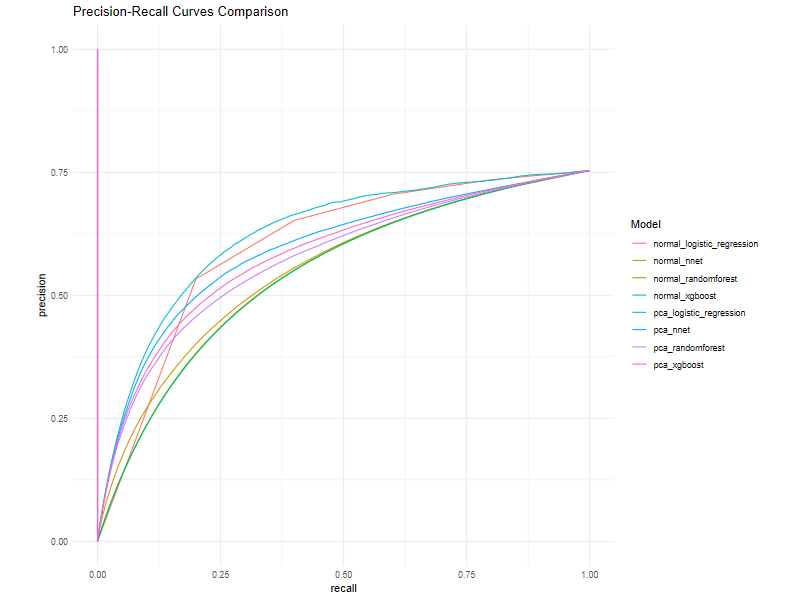

In [76]:
# 3. Precision-Recall Curves
pr_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  pr_curve(truth = status, .pred_Yes) %>%
  autoplot() +
  theme_minimal() +
  labs(
    title = "Precision-Recall Curves Comparison",
    color = "Model"
  )
pr_curves

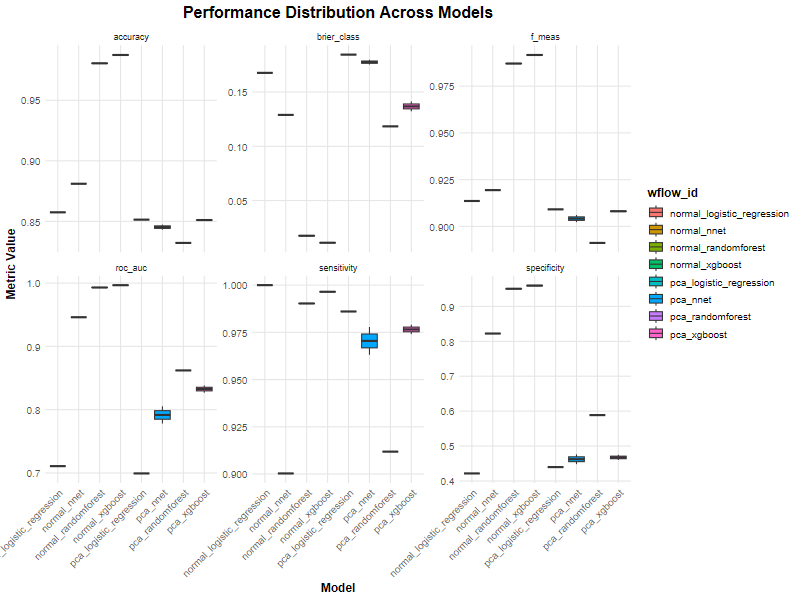

In [77]:
# 4. Performance Distribution Boxplots
metric_distributions <- all_metrics %>%
  ggplot(aes(x = wflow_id, y = mean, fill = wflow_id)) +
  geom_boxplot() +
  facet_wrap(~.metric, scales = "free_y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Performance Distribution Across Models",
    x = "Model",
    y = "Metric Value"
  )

metric_distributions

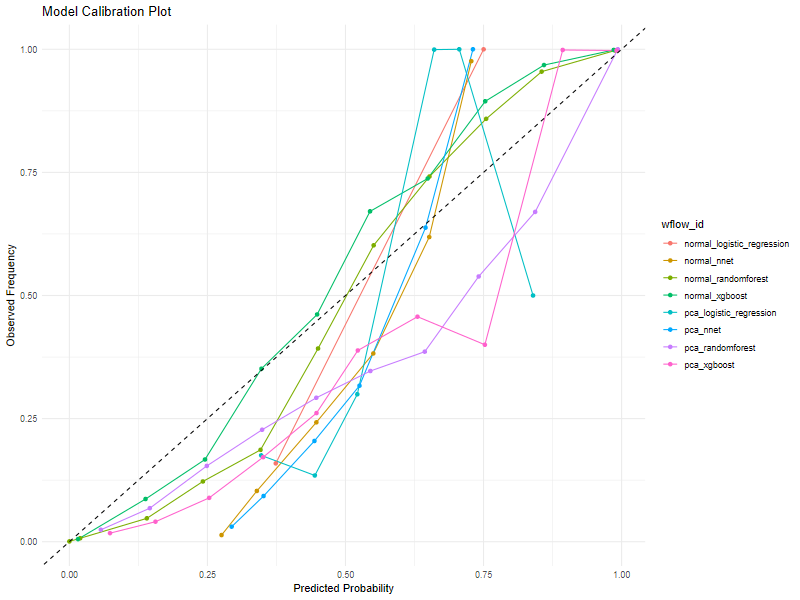

In [78]:
# 5. Model Calibration
calibration_plots <- all_predictions %>%
  group_by(wflow_id) %>%
  mutate(pred_bin = cut(.pred_Yes, breaks = seq(0, 1, by = 0.1))) %>%
  group_by(wflow_id, pred_bin) %>%
  summarise(
    observed_prob = mean(status == "Yes"),
    predicted_prob = mean(.pred_Yes),
    .groups = "drop"
  ) %>%
  ggplot(aes(x = predicted_prob, y = observed_prob, color = wflow_id)) +
  geom_line() +
  geom_point() +
  geom_abline(linetype = "dashed") +  # Ideal calibration line
  theme_minimal() +
  labs(title = "Model Calibration Plot", x = "Predicted Probability", y = "Observed Frequency")

calibration_plots

In [79]:
# 6. Model Rankings
model_rankings <- all_metrics %>%
  group_by(.metric, wflow_id) %>%
  summarise(mean = mean(mean), .groups = "drop") %>%
  mutate(rank = rank(-mean)) %>%
  pivot_wider(names_from = .metric, values_from = c(mean, rank)) %>%
  arrange(rank_roc_auc) %>%
  kable(caption = "Average model rankings based on selected metrics")

print(model_rankings)




Table: Average model rankings based on selected metrics

|wflow_id                   | mean_accuracy| mean_brier_class| mean_f_meas| mean_roc_auc| mean_sensitivity| mean_specificity| rank_accuracy| rank_brier_class| rank_f_meas| rank_roc_auc| rank_sensitivity| rank_specificity|
|:--------------------------|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|
|normal_xgboost             |     0.9873853|        0.0111873|   0.9916704|    0.9965892|        0.9964927|        0.9595362|             7|               48|           5|            2|                3|               13|
|normal_randomforest        |     0.9804852|        0.0176342|   0.9870933|    0.9929603|        0.9902935|        0.9504928|            10|               47|           8|            4|                6|               14|
|normal_nnet                |     0.8810538|        0

In [80]:
# Ensure `wflow_id` is a factor (categorical variable)
all_metrics <- all_metrics %>%
  mutate(wflow_id = as.factor(wflow_id))

# Ensure each fold is treated as a blocking factor
# Create `id` to represent the blocking factor (folds)
all_metrics <- all_metrics %>%
  mutate(id = rep(1:floor(n()/length(unique(wflow_id))),
                  each = length(unique(wflow_id)), length.out = n()))

# Filter only rows where `.metric` is "f1 score"
roc_metrics <- all_metrics %>%
  filter(.metric == "f_meas")

# Ensure `mean` (roc_auc values) is numeric
roc_metrics <- roc_metrics %>%
  mutate(mean = as.numeric(mean))

# Check for missing values
missing_data <- roc_metrics %>%
  group_by(id, wflow_id) %>%
  summarise(n = n(), .groups = "drop") %>%
  pivot_wider(names_from = wflow_id, values_from = n)


# Create properly formatted data for Friedman test
friedman_data <- roc_metrics %>%
  select(id, wflow_id, mean) %>%  
  pivot_wider(
    names_from = wflow_id,
    values_from = mean
  )


# Perform Friedman test
friedman_result <- friedman.test(as.matrix(friedman_data[,-1]))

print("\nFriedman test results:")
print(friedman_result)

# If Friedman test is significant, perform post-hoc analysis
if(friedman_result$p.value < 0.05) {
  # Perform pairwise Wilcoxon signed rank tests with p-value adjustment
  posthoc <- all_metrics %>%
    wilcox_test(
      mean ~ wflow_id,
      paired = TRUE,
      p.adjust.method = "bonferroni"
    )
  
  print("\nPost-hoc analysis results:")
  print(posthoc)
}


[1] "\nFriedman test results:"

	Friedman rank sum test

data:  as.matrix(friedman_data[, -1])
Friedman chi-squared = NaN, df = 7, p-value = NA



: [1m[33mError[39m in `if (friedman_result$p.value < 0.05) ...`:[22m
[33m![39m missing value where TRUE/FALSE needed

Warning message:
Removed 16 rows containing missing values or values outside the scale range (`geom_col()`). 


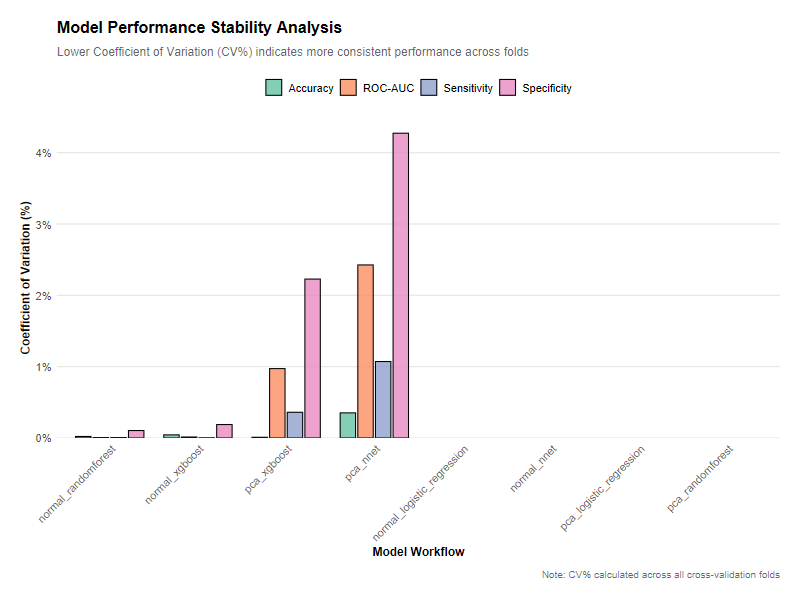

In [81]:
# Stability Plot Analysis
stability_plot <- all_metrics %>%
  # Filter for relevant metrics
  filter(.metric %in% c("accuracy", "roc_auc", "sensitivity", "specificity")) %>%
  # Calculate stability metrics
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    cv = sd_perf / mean_perf * 100,
    .groups = "drop"
  ) %>%
  # Create plot
  ggplot(aes(x = reorder(wflow_id, cv), y = cv, fill = .metric)) +
  geom_col(position = position_dodge(width = 0.8),
           width = 0.7,
           color = "black",
           alpha = 0.8) +
  # Custom color palette
  scale_fill_brewer(palette = "Set2",
                    labels = c("Accuracy", "ROC-AUC", "Sensitivity", "Specificity")) +
  # Formatting
  scale_y_continuous(
    #limits = c(0, max(cv) * 1.1),
    labels = function(x) paste0(round(x, 1), "%"),
    expand = expansion(mult = c(0, 0.05))
  ) +
  # Clean theme
  theme_minimal(base_size = 12, base_family = "Arial") +
  theme(
    plot.title = element_text(size = 16, face = "bold", margin = margin(b = 10)),
    plot.subtitle = element_text(size = 12, color = "grey40", margin = margin(b = 20)),
    plot.caption = element_text(size = 10, color = "grey40", margin = margin(t = 10)),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    legend.position = "top",
    legend.title = element_blank(),
    legend.text = element_text(size = 11),
    legend.margin = margin(b = 10),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_line(color = "grey90"),
    plot.margin = margin(20, 20, 20, 20)
  ) +
  # Labels
  labs(
    title = "Model Performance Stability Analysis",
    subtitle = "Lower Coefficient of Variation (CV%) indicates more consistent performance across folds",
    x = "Model Workflow",
    y = "Coefficient of Variation (%)",
    caption = "Note: CV% calculated across all cross-validation folds"
  )

# Display the plot
stability_plot

In [82]:
performance_table <- overall_comparison %>%
  arrange(desc(mean_perf)) %>% # Sort by performance
  kable(format = "html", digits = 3, caption = "Model Performance Summary") %>%
  kable_styling(full_width = FALSE, bootstrap_options = c("striped", "hover", "condensed")) %>%
  row_spec(0, bold = TRUE) %>%  # Make header bold
  column_spec(2:3, width = "15em") %>% # Adjust column width
  pack_rows("Top Performing Models", 1, 3, label_row_css = "font-weight: bold; background-color: #e6f3ff;") # Highlight top 3


In [83]:
all_metrics %>%
  group_by(.metric, wflow_id) %>%
  summarise(mean = mean(mean), .groups = "drop") %>%
  mutate(rank = rank(-mean)) %>%
  pivot_wider(names_from = .metric, values_from = c(mean, rank)) %>%
  arrange(rank_roc_auc) %>%
  mutate(wflow_id = as.character(wflow_id))-> model_rankings

model_rankings

# A tibble: 8 × 13
  wflow_id        mean_accuracy mean_brier_class mean_f_meas mean_roc_auc mean_sensitivity mean_specificity
  <chr>                   <dbl>            <dbl>       <dbl>        <dbl>            <dbl>            <dbl>
1 normal_xgboost          0.987           0.0112       0.992        0.997            0.996            0.960
2 normal_randomf…         0.980           0.0176       0.987        0.993            0.990            0.950
3 normal_nnet             0.881           0.129        0.919        0.946            0.900            0.822
4 pca_randomfore…         0.832           0.118        0.891        0.862            0.912            0.589
5 pca_xgboost             0.851           0.137        0.908        0.833            0.977            0.467
6 pca_nnet                0.845           0.178        0.904        0.792            0.970            0.462
7 normal_logisti…         0.857           0.168        0.914        0.711            1                0.422
8 pca_log

In [84]:
best_wflow <- model_rankings %>%
  slice(1) %>% 
  pull(wflow_id) 


best_results <- race_results %>% 
  extract_workflow_set_result(best_wflow) %>% 
  select_best(metric = "f_meas")

print(best_results)

Warning message:
Metric "accuracy" was used to evaluate model candidates in the race but "f_meas" has been chosen to rank
the candidates. These results may not agree with the race. 


# A tibble: 1 × 7
   mtry min_n tree_depth learn_rate loss_reduction sample_size .config              
  <int> <int>      <int>      <dbl>          <dbl>       <dbl> <chr>                
1    24    24          4      0.116       0.000866       0.780 Preprocessor1_Model02


In [85]:
race_results %>% 
  extract_workflow(best_wflow) %>% 
  finalize_workflow(best_results) %>% 
  last_fit(loan_split) -> final_fit

In [86]:
collect_metrics(final_fit)

# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.988  Preprocessor1_Model1
2 roc_auc     binary        0.997  Preprocessor1_Model1
3 brier_class binary        0.0108 Preprocessor1_Model1

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[[1]]
# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.988  Preprocessor1_Model1
2 roc_auc     binary        0.997  Preprocessor1_Model1
3 brier_class binary        0.0108 Preprocessor1_Model1

[[2]]



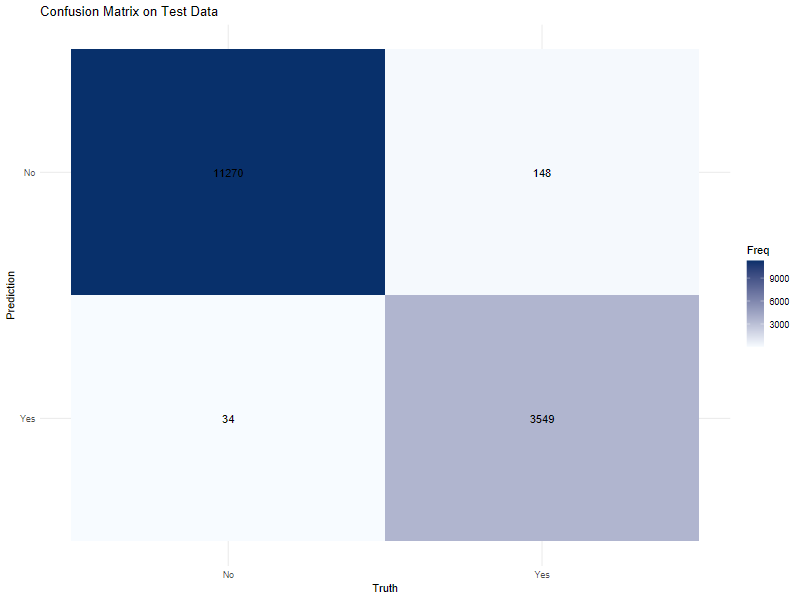

In [87]:
final_fit %>% 
  collect_predictions() %>% 
  conf_mat(truth = status, 
      estimate = .pred_class) -> conf_mat

confusion_matrix <- conf_mat %>%
  autoplot(type = "heatmap") +
  labs(title = "Confusion Matrix on Test Data") +
  scale_fill_gradient(low = "#f7fbff", high = "#08306b") +
  theme_minimal()

final_metrics <- collect_metrics(final_fit)
print(list(final_metrics, confusion_matrix))

